


**Configurações usadas**

### **InputsConfig**  
- **EMBEDDING_DIM**: 128  
- **SLIDE_WINDOW**: 9  
- **PAD_VALUE**: 0  
- **TIMEOUT_TEST**: None  
- **NEXT_TARGET**: None  
- **CATEGORY_TARGET**: None  

---

### **MTLModelConfig**  
- **NUM_CLASSES**: 7  
- **BATCH_SIZE**: 2048  
- **EPOCHS**: 50  
- **LEARNING_RATE**: 0.0001  
- **K_FOLDS**: 3  

---

### **ModelParameters**  
- **INPUT_DIM**: 64
- **SHARED_LAYER_SIZE**: 256  
- **NUM_HEADS**: 8  
- **NUM_LAYERS**: 4  
- **SEQ_LENGTH**: 9  
- **NUM_SHARED_LAYERS**: 4  
- **ENCODER_OUTPUT_SIZE**: 256  
- **EXPERT_HIDDEN_SIZE**: 256  
- **EXPERT_OUTPUT_SIZE**: 256  
- **NUM_EXPERTS**: 9  


# Alabama

In [ ]:
ESTADO = "alabama"

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [ ]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [ ]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [ ]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


In [ ]:
import os
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)


## HGI com Time + Location Encoding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/poi_embedding.torch'

### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/filtrado.csv')

### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pois_gowalla.csv'

In [ ]:
import pandas as pd
teste = pd.read_csv(f"{output_state_dir}/pois_gowalla.csv")
teste.shape

(10269, 4)

In [ ]:
time_csv = pd.read_csv(f"{diretorio_region_embedding}/time_encoder_embeddings_sin_checkin_{ESTADO.lower()}.csv")
time_csv.shape

(93402, 130)

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"

def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (
        chk.dropna(subset=["category"])
           .groupby("placeid")["category"]
           .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    )
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True,
    peso_location=0.5,
):
    peso_time = 1.0 - peso_location

    emb_loc = load_tensor(path_torch)
    V, D = emb_loc.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    loc_cols = [f"loc_{i}" for i in range(D)]
    df_loc = pd.DataFrame(emb_loc, columns=loc_cols)
    df_loc.insert(0, "placeid", placeids)
    df_loc["placeid"] = df_loc["placeid"].astype(str)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df_loc["category"] = df_loc["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df_loc["category"] = np.nan
    else:
        df_loc["category"] = np.nan

    time_csv = f"{diretorio_region_embedding}/time_encoder_embeddings_sin_checkin_{ESTADO}.csv"
    if not os.path.exists(time_csv):
        raise FileNotFoundError(f"Arquivo de time embeddings não encontrado: {time_csv}")

    time_df = pd.read_csv(time_csv)
    if "placeid" not in time_df.columns:
        raise KeyError("time_encoder_embeddings_sin_checkin CSV precisa conter a coluna 'placeid'.")

    time_df["placeid"] = time_df["placeid"].astype(str)

    time_emb_cols = [str(i) for i in range(D) if str(i) in time_df.columns]
    if len(time_emb_cols) != D:
        print(f"[AVISO] Esperava {D} colunas de embedding de tempo (0..{D-1}), "
              f"mas encontrei {len(time_emb_cols)}. Usando apenas as existentes.")

    time_agg = (
        time_df
        .groupby("placeid")[time_emb_cols]
        .mean()
        .reset_index()
    )

    rename_map = {c: f"time_{c}" for c in time_emb_cols}
    time_agg = time_agg.rename(columns=rename_map)

    merged = df_loc.merge(time_agg, on="placeid", how="inner")

    final_emb_cols = [str(i) for i in range(D)]
    for i in range(D):
        loc_col = f"loc_{i}"
        time_col = f"time_{i}"
        if loc_col not in merged.columns or time_col not in merged.columns:
            raise KeyError(f"Colunas esperadas não encontradas: {loc_col} ou {time_col}")
        merged[str(i)] = (
            peso_location * merged[loc_col] +
            peso_time     * merged[time_col]
        )

    cols_final = ["placeid"] + final_emb_cols + ["category"]
    df_final = merged[cols_final]

    df_final.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    print("Shape final:", df_final.shape)
    print(f"peso_location = {peso_location:.2f} | peso_time = {peso_time:.2f}")
    return df_final




In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"

def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (
        chk.dropna(subset=["category"])
           .groupby("placeid")["category"]
           .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    )
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv_concat(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True,
):
    emb_loc = load_tensor(path_torch)
    V, D = emb_loc.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    loc_cols = [f"loc_{i}" for i in range(D)]
    df_loc = pd.DataFrame(emb_loc, columns=loc_cols)
    df_loc.insert(0, "placeid", placeids)
    df_loc["placeid"] = df_loc["placeid"].astype(str)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df_loc["category"] = df_loc["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df_loc["category"] = np.nan
    else:
        df_loc["category"] = np.nan

    time_csv = f"{diretorio_region_embedding}/time_encoder_embeddings_sin_checkin_{ESTADO}.csv"
    if not os.path.exists(time_csv):
        raise FileNotFoundError(f"Arquivo de time embeddings não encontrado: {time_csv}")

    time_df = pd.read_csv(time_csv)
    if "placeid" not in time_df.columns:
        raise KeyError("time_encoder_embeddings_sin_checkin CSV precisa conter a coluna 'placeid'.")

    time_df["placeid"] = time_df["placeid"].astype(str)

    time_emb_cols = [str(i) for i in range(D) if str(i) in time_df.columns]
    if len(time_emb_cols) != D:
        print(f"[AVISO] Esperava {D} colunas de embedding de tempo (0..{D-1}), "
              f"mas encontrei {len(time_emb_cols)}. Usando apenas as existentes.")
        D = len(time_emb_cols)

    time_agg = (
        time_df
        .groupby("placeid")[time_emb_cols]
        .mean()
        .reset_index()
    )

    rename_map = {c: f"time_{c}" for c in time_emb_cols}
    time_agg = time_agg.rename(columns=rename_map)
    time_cols = [f"time_{c}" for c in time_emb_cols]

    merged = df_loc.merge(time_agg, on="placeid", how="inner")
    print("[merged] shape (loc+time+category):", merged.shape)

    concat_array = np.hstack([
        merged[loc_cols].values.astype(np.float32),
        merged[time_cols].values.astype(np.float32),
    ])

    new_D = concat_array.shape[1]
    emb_cols = [str(i) for i in range(new_D)]
    df_final = pd.DataFrame(concat_array, columns=emb_cols)
    df_final.insert(0, "placeid", merged["placeid"].values)
    df_final["category"] = merged["category"].values

    df_final.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    print("Shape final:", df_final.shape)
    print(f"Dim original loc = {len(loc_cols)}, dim time = {len(time_cols)}, dim concat = {new_D}")
    return df_final


In [ ]:
def limpar_pasta_output():
    pasta = os.path.join(diretorio_principal, "data", "output", ESTADO,"pre-processing")
    if not os.path.exists(pasta):
        print(f"[AVISO] Pasta não encontrada: {pasta}")
        return

    arquivos = os.listdir(pasta)
    if not arquivos:
        print(f"[INFO] A pasta {pasta} já está vazia.")
        return

    for nome in arquivos:
        caminho = os.path.join(pasta, nome)
        try:
            if os.path.isfile(caminho) or os.path.islink(caminho):
                os.remove(caminho)
            elif os.path.isdir(caminho):
                shutil.rmtree(caminho)
        except Exception as e:
            print(f"[ERRO] Falha ao remover {caminho}: {e}")

    print(f"[OK] Todos os arquivos da pasta {pasta} foram removidos.")


### Treino com novo modelo de embeddings pelo HGI

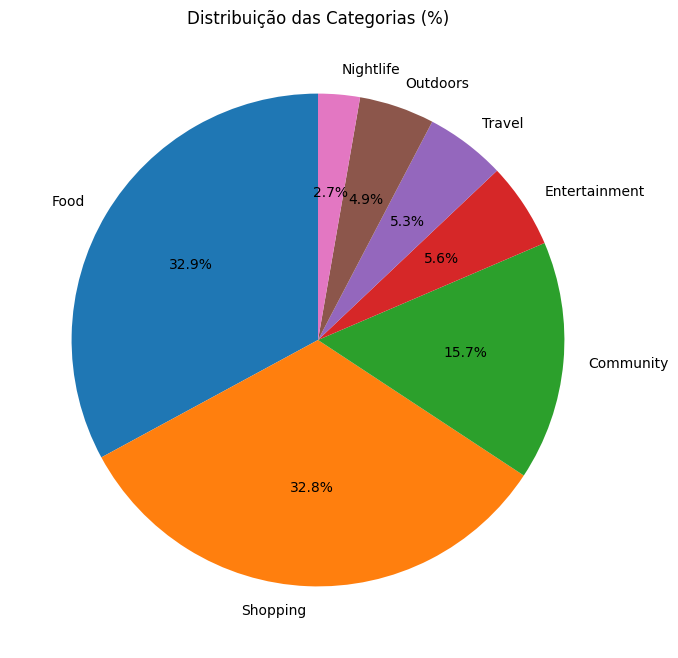

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(f"{pasta_output}/embeddings.csv")

category_counts = df["category"].value_counts()

category_percent = category_counts / category_counts.sum() * 100

plt.figure(figsize=(8, 8))
plt.pie(category_percent, labels=category_percent.index, autopct="%.1f%%", startangle=90)
plt.title("Distribuição das Categorias (%)")
plt.show()


In [ ]:
limpar_pasta_output()

[INFO] A pasta /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing já está vazia.


### Concat


In [ ]:
limpar_pasta_output()

[OK] Todos os arquivos da pasta /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing foram removidos.


In [ ]:
save_poi_torch_to_csv_concat(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True,
)


[merged] shape (loc+time+category): (10269, 258)
Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama//embeddings.csv
Shape final: (10269, 258)
Dim original loc = 128, dim time = 128, dim concat = 256


placeid         0         1         2         3         4         5  \
0         9531 -0.002474  0.059986 -0.002295 -0.000803  0.234692 -0.007992   
1         9532  0.140575 -0.003843  0.021874  0.174809  0.083200  0.053388   
2         9533 -0.003341 -0.004962  0.093748  0.221308  0.266410 -0.004393   
3         9593  0.247601  0.133715  0.108246 -0.002567  0.124402 -0.002913   
4         9693 -0.000302  0.140361  0.105991 -0.000716 -0.002154  0.090549   
...        ...       ...       ...       ...       ...       ...       ...   
10264  7565433  0.021450  0.072355 -0.001168  0.072848 -0.001720  0.010918   
10265  7568997  0.072522  0.034201  0.007113 -0.001206  0.029790 -0.003794   
10266  7570992  0.005616 -0.001120 -0.001387 -0.002191 -0.001589  0.008982   
10267  7574223  0.121695  0.092261 -0.001169  0.051865  0.019046  0.006539   
10268  7574363 -0.000122  0.064160 -0.002503  0.031166 -0.003491  0.037112   

              6         7         8  ...       247       248       249  \
0      0.042493 -0.003062 -0.001823  ...  0.030027  0.007616 -0.000390   
1      0.043978  0.047374 -0.009048  ...  0.072057 -0.023215  0.029716   
2      0.042726 -0.003825  0.028179  ...  0.013223  0.006437 -0.012332   
3      0.101058 -0.001720 -0.004418  ... -0.010655  0.001565  0.008363   
4      0.193433 -0.000475  0.108875  ...  0.013560  0.021689  0.004806   
...         ...       ...       ...  ...       ...       ...       ...   
10264  0.070253 -0.001454 -0.002042  ... -0.318342  0.007554 -0.072462   
10265 -0.000508  0.000042 -0.000727  ... -0.152846 -0.090260  0.050146   
10266 -0.000145  0.010624  0.015214  ...  0.022142  0.041738  0.016882   
10267  0.057375 -0.000995 -0.002093  ...  0.218197  0.051614  0.059886   
10268  0.071377  0.024259  0.002924  ...  0.218332  0.049394  0.059467   

            250       251       252       253       254       255  \
0     -0.022362 -0.025652  0.008494 -0.042339 -0.018262  0.020036   
1     -0.005699 -0.030872  0.010629 -0.034339 -0.009577  0.075994   
2     -0.013834 -0.016888  0.027711 -0.036169  0.000938  0.018830   
3     -0.004586  0.025979 -0.010244  0.006459  0.010584 -0.025314   
4     -0.017549  0.029244  0.001572 -0.016775 -0.000865  0.024482   
...         ...       ...       ...       ...       ...       ...   
10264 -0.006424  0.164963  0.013319  0.147616 -0.004967 -0.387907   
10265  0.053854  0.076275 -0.086293  0.173518  0.043171  0.001835   
10266 -0.095393  0.007730  0.015932  0.019608  0.002362 -0.038228   
10267 -0.056614 -0.030027 -0.008813 -0.171413 -0.002910  0.294799   
10268 -0.056271 -0.034594 -0.008286 -0.172914 -0.002651  0.294199   

            category  
0           Shopping  
1          Community  
2           Outdoors  
3             Travel  
4      Entertainment  
...              ...  
10264           Food  
10265       Shopping  
10266         Travel  
10267           Food  
10268       Shopping  

[10269 rows x 258 columns]

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet/src/data/create_input.py:415: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged[c] = merged[f"{c}_emb"] + merged[f"{c}_loc"]
/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet/src/data/create_input.py:415: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged[c] = merged[f"{c}_emb"] + merged[f"{c}_loc"]
/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet/src/data/create_input.py:415: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-11-06 23:00:51.405621: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 23:00:51.423018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762470051.444331   36603 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762470051.450693   36603 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762470051.467127   36603 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251024_1346"

### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score  \
0      Community  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
1  Entertainment  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
2           Food  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
3      Nightlife  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
4       Outdoors  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   

              support  
0   81366.67 ± 901.85  
1   24266.67 ± 757.19  
2  139800.00 ± 781.02  
3   16866.67 ± 404.15  
4  19066.67 ± 1159.02

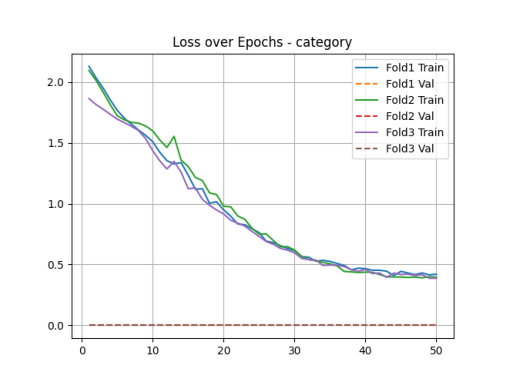

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score          support
0      Community   53.78 ± 2.75  75.65 ± 10.08   62.55 ± 2.40  4366.67 ± 57.74
1  Entertainment   18.84 ± 4.09   23.21 ± 9.28   20.62 ± 6.35   733.33 ± 57.74
2           Food   41.92 ± 8.34  12.22 ± 10.84  16.87 ± 13.45   6000.00 ± 0.00
3      Nightlife  34.44 ± 15.03   24.36 ± 8.41   26.27 ± 4.81  1233.33 ± 57.74
4       Outdoors   32.06 ± 7.78  54.03 ± 18.45   39.60 ± 9.67  1533.33 ± 57.74

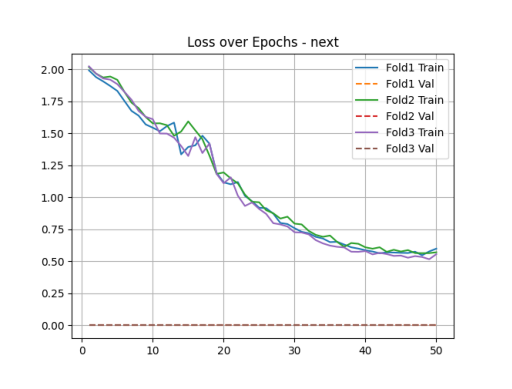

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

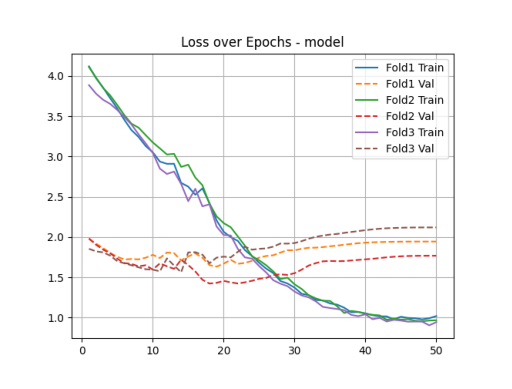

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## POI Embedding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [ ]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [ ]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_Alabama.csv')

#### pois_gowalla

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pois_gowalla.csv'

#### poi-encoder-gowalla-h3.tensor

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,f"poi-encoder-gowalla-h3_{ESTADO.lower()}.tensor")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi-encoder-gowalla-h3.tensor")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/poi-encoder-gowalla-h3.tensor'

In [ ]:
import sys
import numpy as np
import pandas as pd
import torch

pois_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/pois_gowalla.csv")
tensor_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/poi-encoder-gowalla-h3.tensor")
filtrado_path = Path(f"{diretorio_principal}/data/checkins/checkins_{ESTADO.capitalize()}.csv")

def load_embedding_matrix(tensor_path: str, key: str = f"in_embed_{ESTADO.lower()}.weight") -> np.ndarray:
    """
    Carrega o .tensor (checkpoint PyTorch) e retorna um numpy array (num_fclass, emb_dim).
    """
    ckpt = torch.load(tensor_path, map_location="cpu")
    if key not in ckpt:
        raise KeyError(f"Chave '{key}' não encontrada no arquivo '{tensor_path}'. "
                       f"Chaves disponíveis: {list(ckpt.keys())[:10]}...")
    W = ckpt[key]
    if not isinstance(W, torch.Tensor):
        raise TypeError(f"Valor em '{key}' não é um torch.Tensor (veio {type(W)}).")
    if W.ndim != 2:
        raise ValueError(f"Esperado tensor 2D em '{key}', mas veio shape {tuple(W.shape)}.")
    return W.detach().cpu().numpy()


def build_output_df(pois_path: str, W: np.ndarray, filtrado_path: str) -> pd.DataFrame:
    """
    Gera o DataFrame final com:
      - placeid (copiado de feature_id)
      - emb_0 ... emb_(D-1) mapeados por fclass
      - category (join com filtrado.csv via placeid)
    """
    pois = pd.read_csv(pois_path)
    if "feature_id" not in pois.columns or "fclass" not in pois.columns:
        raise KeyError("O arquivo pois_gowalla.csv deve conter as colunas 'feature_id' e 'fclass'. "
                       f"Colunas encontradas: {list(pois.columns)}")

    pois["feature_id"] = pois["feature_id"].astype(str)
    try:
        pois["fclass"] = pois["fclass"].astype(int)
    except Exception as e:
        raise ValueError("Falha ao converter 'fclass' para int. "
                         "Verifique se há valores não numéricos.") from e

    num_classes, emb_dim = W.shape

    n = len(pois)
    emb = np.full((n, emb_dim), np.nan, dtype=float)

    valid = (pois["fclass"] >= 0) & (pois["fclass"] < num_classes)
    if not valid.all():
        invalid_rows = (~valid).sum()

    emb[valid.values] = W[pois.loc[valid, "fclass"].to_numpy()]

    emb_cols = [f"{i}" for i in range(emb_dim)]
    out = pd.DataFrame(emb, columns=emb_cols)
    out.insert(0, "placeid", pois["feature_id"].astype(str))

    filtrado = pd.read_csv(filtrado_path)

    if "placeid" not in filtrado.columns:
        if "feature_id" in filtrado.columns:
            filtrado = filtrado.rename(columns={"feature_id": "placeid"})
        else:
            raise KeyError("O arquivo filtrado.csv deve conter a coluna 'placeid'. "
                           f"Colunas encontradas: {list(filtrado.columns)}")

    if "category" not in filtrado.columns:
        raise KeyError("O arquivo filtrado.csv deve conter a coluna 'category'.")

    filtrado["placeid"] = filtrado["placeid"].astype(str)

    out = out.merge(filtrado[["placeid", "category"]], on="placeid", how="left")



    return out



In [ ]:
W =load_embedding_matrix(tensor_path)
out_df = build_output_df(pois_path, W, filtrado_path)


In [ ]:
pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
out_df.to_csv(f"{pasta_output}/embeddings-poi-encoder.csv", index=False)


In [ ]:
out_df.shape

(93402, 258)

### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 200, Total visit sequences: 654
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 200/200 [00:00<00:00, 36429.44it/s]
nextpoi_sequences shape: (654, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 1/1 [00:00<00:00,  2.78it/s, rows_written=654]
Finished: wrote 654 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-11-04 13:20:59.495556: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-04 13:20:59.513017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762262459.534292   21746 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762262459.540729   21746 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762262459.557059   21746 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251031_2029"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category      precision         recall      f1-score          support
0      Community    9.02 ± 4.76  22.47 ± 19.37  10.65 ± 4.61  1960.00 ± 54.77
1  Entertainment    0.00 ± 0.00    0.00 ± 0.00   0.00 ± 0.00  1240.00 ± 54.77
2           Food   38.74 ± 3.31   53.22 ± 8.92  44.45 ± 2.85  8380.00 ± 44.72
3      Nightlife    0.00 ± 0.00    0.00 ± 0.00   0.00 ± 0.00  1680.00 ± 44.72
4       Outdoors  29.88 ± 40.00    8.48 ± 7.95   9.70 ± 6.32  1880.00 ± 44.72

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category     precision         recall       f1-score          support
0      Community   8.14 ± 6.28  18.16 ± 14.37   10.11 ± 6.14  1960.00 ± 54.77
1  Entertainment   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00  1240.00 ± 54.77
2           Food  39.14 ± 3.61  41.48 ± 25.38  36.78 ± 10.34  8380.00 ± 44.72
3      Nightlife   1.54 ± 3.44    3.53 ± 7.89    2.14 ± 4.79  1680.00 ± 44.72
4       Outdoors  8.21 ± 11.25    5.26 ± 9.12    5.88 ± 9.22  1880.00 ± 44.72

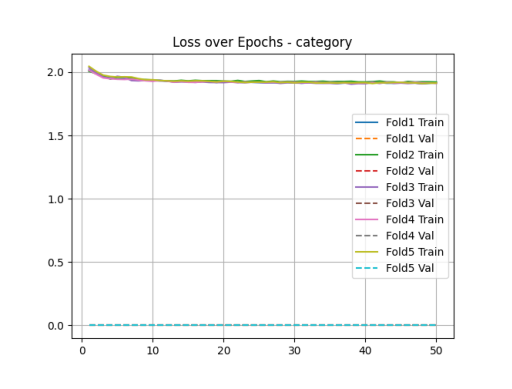

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score          support
0      Community  57.59 ± 10.01  63.36 ± 11.05   58.93 ± 1.49  2620.00 ± 44.72
1  Entertainment    9.95 ± 9.57  18.00 ± 10.37   11.61 ± 8.52   440.00 ± 54.77
2           Food   33.77 ± 7.99   17.78 ± 9.94  22.60 ± 10.26   3600.00 ± 0.00
3      Nightlife   16.11 ± 4.97   21.43 ± 6.68   18.10 ± 5.16   740.00 ± 54.77
4       Outdoors  31.41 ± 11.00   43.56 ± 1.99   35.73 ± 6.92   920.00 ± 44.72

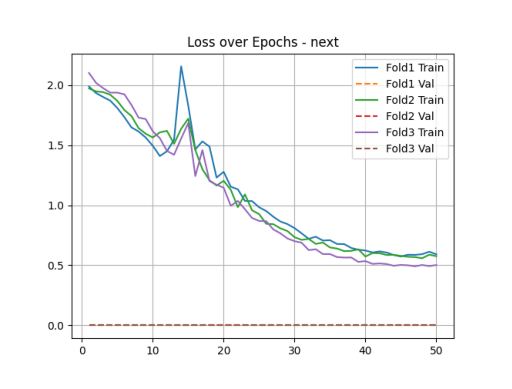

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

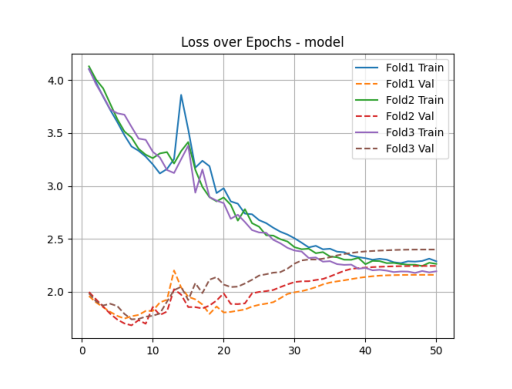

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## HGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

#### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/poi_embedding.torch'

#### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/filtrado.csv')

#### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pois_gowalla.csv'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama//embeddings.csv


placeid         0         1         2         3         4         5  \
0         9531 -0.328018 -0.279717 -0.268858 -0.025124 -0.033602  0.831421   
1         9532 -0.212724 -0.188304 -0.040483 -0.244203  1.012444  1.173037   
2         9533  0.957083 -0.120902  0.103594 -0.226602  0.106776  0.596069   
3         9593 -0.033946  0.299042  0.101730 -0.204093  0.044489  0.653744   
4         9693  0.615521 -0.025080 -0.066807 -0.233809 -0.017595  0.547271   
...        ...       ...       ...       ...       ...       ...       ...   
10264  7565433 -0.317049 -0.118215 -0.024992 -0.075344 -0.097142  0.470303   
10265  7568997  0.111724 -0.083904  0.190910  0.032612 -0.245301  0.713871   
10266  7570992  0.049874 -0.004915 -0.391894  0.467625  0.852172  0.454604   
10267  7574223 -0.295706  0.242828 -0.606082 -0.171838  1.712261  0.892785   
10268  7574363 -0.160191 -0.025299 -0.118098 -0.441647  0.820836  0.780606   

              6         7         8  ...        55        56        57  \
0      0.487451  0.345670 -0.051999  ...  0.382835  0.569170  0.062280   
1     -0.368704 -0.216277  0.044884  ... -0.090151  0.303618  0.442501   
2     -0.405396  0.028514  0.509419  ... -0.079732  0.831397  0.024735   
3      0.662394  0.550874  0.672326  ... -0.085716  0.441036  0.209071   
4     -0.263094 -0.132398 -0.088840  ... -0.188026  1.086916 -0.036607   
...         ...       ...       ...  ...       ...       ...       ...   
10264  1.184643 -0.310203  0.385223  ...  1.237868 -0.138529  1.750363   
10265  1.140990 -0.011070 -0.039734  ...  0.244286 -0.005502  0.883621   
10266  0.777993  0.827893 -0.138480  ...  0.350916  0.725459 -0.101077   
10267  1.275130  0.676823  1.093236  ...  2.273987 -0.580897  1.323805   
10268 -0.135789  0.593972 -0.227308  ... -0.098488  0.860860  0.346416   

             58        59        60        61        62        63  \
0     -0.175719  0.631150 -0.055097  0.027944  0.636096  0.206160   
1     -0.290301  0.510194 -0.057238 -0.213825  0.169952  0.980230   
2     -0.035905  0.493928 -0.049237  1.114538 -0.022972  0.607717   
3      1.268344 -0.063430 -0.185252  0.540702  0.180796 -0.019045   
4     -0.170019  0.699518 -0.245074  0.281830 -0.058471  0.175323   
...         ...       ...       ...       ...       ...       ...   
10264 -0.187174  0.915760 -0.043957  0.691891  0.626277  0.029799   
10265 -0.288049  0.223249 -0.191501  0.471388 -0.290527  0.050230   
10266 -0.175795  1.246596  0.750474  0.479635 -0.163431 -0.023801   
10267  0.547652  2.097080 -0.205113  0.026762 -0.269167  0.473824   
10268 -0.206023 -0.031804 -0.141015  1.123400  0.464607 -0.099695   

            category  
0           Shopping  
1          Community  
2           Outdoors  
3             Travel  
4      Entertainment  
...              ...  
10264           Food  
10265       Shopping  
10266         Travel  
10267           Food  
10268       Shopping  

[10269 rows x 66 columns]

### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 1432, Total visit sequences: 10426
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 1432/1432 [00:00<00:00, 18722.47it/s]
nextpoi_sequences shape: (10426, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 2/2 [00:07<00:00,  3.55s/it, rows_written=10426]
Finished: wrote 10426 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-23 21:03:55.217823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761253435.237416    7045 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761253435.243346    7045 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761253435.258139    7045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761253435.258164    7045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761253435.258169    7045 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251023_2104"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category     precision        recall      f1-score            support
0      Community  77.41 ± 4.07  75.57 ± 1.23  76.43 ± 1.97   53766.67 ± 57.74
1  Entertainment  71.98 ± 1.99  66.21 ± 0.86  68.96 ± 0.92   19233.33 ± 57.74
2           Food  79.85 ± 0.55  77.89 ± 1.17  78.86 ± 0.80  112633.33 ± 57.74
3      Nightlife  67.37 ± 1.99  63.72 ± 4.08  65.42 ± 2.03    9366.67 ± 57.74
4       Outdoors  71.63 ± 1.75  68.24 ± 2.46  69.89 ± 2.09    16900.00 ± 0.00

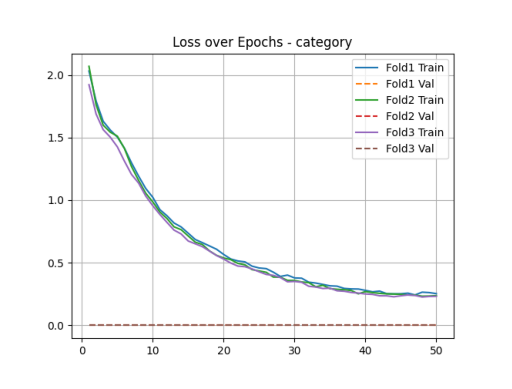

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category     precision         recall      f1-score            support
0      Community  39.23 ± 4.29   49.51 ± 5.02  43.54 ± 2.83   68133.33 ± 57.74
1  Entertainment  15.23 ± 1.78  33.05 ± 10.23  20.33 ± 0.28   20466.67 ± 57.74
2           Food  46.46 ± 4.02   23.77 ± 7.46  30.70 ± 6.14  118366.67 ± 57.74
3      Nightlife  14.41 ± 2.77   34.31 ± 7.86  19.83 ± 1.70    13600.00 ± 0.00
4       Outdoors  13.52 ± 2.40   19.31 ± 9.39  14.92 ± 1.33   16566.67 ± 57.74

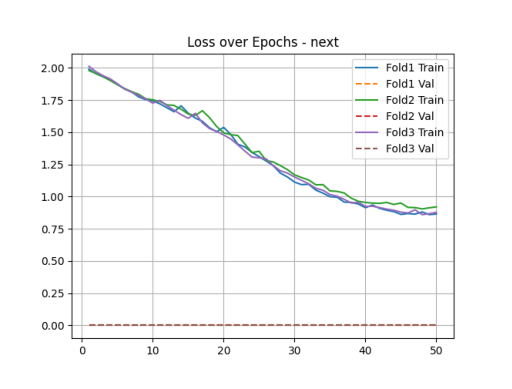

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

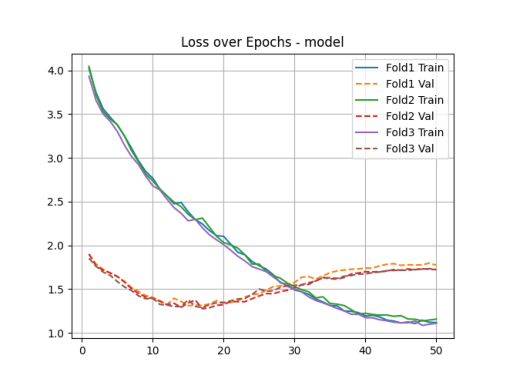

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## DGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [ ]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [ ]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_Alabama.csv')

# Nebraska

In [ ]:
ESTADO = "nebraska"

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [ ]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [ ]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [ ]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


## HGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/poi_embedding.torch'

### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/filtrado.csv')

### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/pois_gowalla.csv'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


KeyboardInterrupt: 

### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 200, Total visit sequences: 654
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 200/200 [00:00<00:00, 29576.93it/s]
nextpoi_sequences shape: (654, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/poi-sequences.csv

Generating next POI input data...
Resuming from row 654 (found existing file).
Batches: 0it [00:00, ?it/s]
Finished: wrote 654 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-06 12:36:40.877264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759754200.924851    8364 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759754200.938659    8364 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759754200.975348    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975407    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975417    8364 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251006_1236"

### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category      precision        recall      f1-score           support
0      Community  64.08 ± 14.18  66.26 ± 8.50  64.53 ± 9.53   3266.67 ± 57.74
1  Entertainment  47.29 ± 18.12  19.37 ± 0.55  26.92 ± 3.10   2066.67 ± 57.74
2           Food   71.58 ± 3.02  76.38 ± 5.53  73.78 ± 2.55  13966.67 ± 57.74
3      Nightlife   57.85 ± 7.62  54.76 ± 5.46  55.84 ± 2.63    2800.00 ± 0.00
4       Outdoors   67.92 ± 9.16  69.19 ± 3.08  68.28 ± 4.81   3133.33 ± 57.74

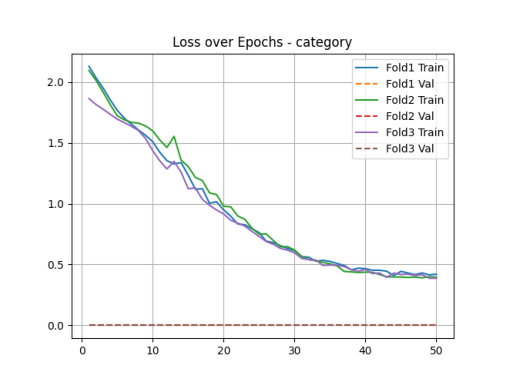

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score          support
0      Community   53.78 ± 2.75  75.65 ± 10.08   62.55 ± 2.40  4366.67 ± 57.74
1  Entertainment   18.84 ± 4.09   23.21 ± 9.28   20.62 ± 6.35   733.33 ± 57.74
2           Food   41.92 ± 8.34  12.22 ± 10.84  16.87 ± 13.45   6000.00 ± 0.00
3      Nightlife  34.44 ± 15.03   24.36 ± 8.41   26.27 ± 4.81  1233.33 ± 57.74
4       Outdoors   32.06 ± 7.78  54.03 ± 18.45   39.60 ± 9.67  1533.33 ± 57.74

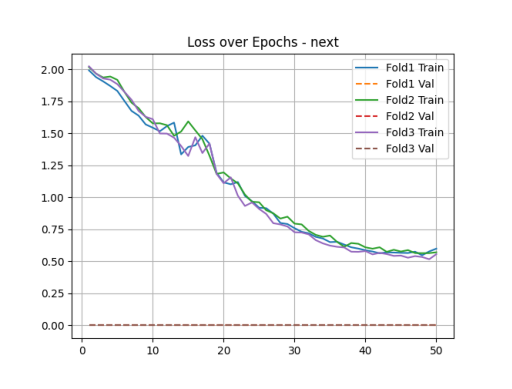

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

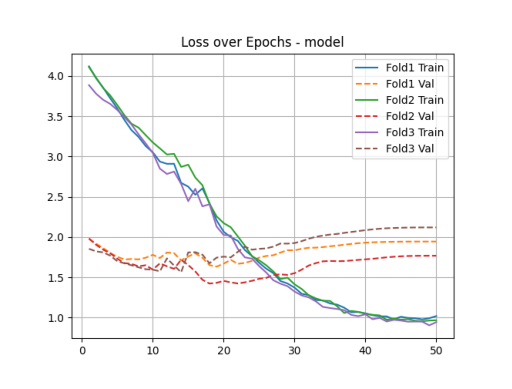

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## DGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

## POI Embedding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [ ]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [ ]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_Nebraska.csv')

#### pois_gowalla

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/pois_gowalla.csv'

#### poi-encoder-gowalla-h3.tensor

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"poi-encoder-gowalla-h3.tensor")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi-encoder-gowalla-h3.tensor")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/poi-encoder-gowalla-h3.tensor'

In [ ]:
!pip install torch

In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install -q --extra-index-url https://download.pytorch.org/whl/cu121 \
  torch torchvision torchaudio


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import sys
import numpy as np
import pandas as pd
import torch

pois_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/pois_gowalla.csv")
tensor_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/poi-encoder-gowalla-h3.tensor")
filtrado_path = Path(f"{diretorio_principal}/data/checkins/checkins_{ESTADO.capitalize()}.csv")

def load_embedding_matrix(tensor_path: str, key: str = "in_embed.weight") -> np.ndarray:
    """
    Carrega o .tensor (checkpoint PyTorch) e retorna um numpy array (num_fclass, emb_dim).
    """
    ckpt = torch.load(tensor_path, map_location="cpu")
    if key not in ckpt:
        raise KeyError(f"Chave '{key}' não encontrada no arquivo '{tensor_path}'. "
                       f"Chaves disponíveis: {list(ckpt.keys())[:10]}...")
    W = ckpt[key]
    if not isinstance(W, torch.Tensor):
        raise TypeError(f"Valor em '{key}' não é um torch.Tensor (veio {type(W)}).")
    if W.ndim != 2:
        raise ValueError(f"Esperado tensor 2D em '{key}', mas veio shape {tuple(W.shape)}.")
    return W.detach().cpu().numpy()


def build_output_df(pois_path: str, W: np.ndarray, filtrado_path: str) -> pd.DataFrame:
    """
    Gera o DataFrame final com:
      - placeid (copiado de feature_id)
      - emb_0 ... emb_(D-1) mapeados por fclass
      - category (join com filtrado.csv via placeid)
    """
    pois = pd.read_csv(pois_path)
    if "feature_id" not in pois.columns or "fclass" not in pois.columns:
        raise KeyError("O arquivo pois_gowalla.csv deve conter as colunas 'feature_id' e 'fclass'. "
                       f"Colunas encontradas: {list(pois.columns)}")

    pois["feature_id"] = pois["feature_id"].astype(str)
    try:
        pois["fclass"] = pois["fclass"].astype(int)
    except Exception as e:
        raise ValueError("Falha ao converter 'fclass' para int. "
                         "Verifique se há valores não numéricos.") from e

    num_classes, emb_dim = W.shape

    n = len(pois)
    emb = np.full((n, emb_dim), np.nan, dtype=float)

    valid = (pois["fclass"] >= 0) & (pois["fclass"] < num_classes)
    if not valid.all():
        invalid_rows = (~valid).sum()

    emb[valid.values] = W[pois.loc[valid, "fclass"].to_numpy()]

    emb_cols = [f"{i}" for i in range(emb_dim)]
    out = pd.DataFrame(emb, columns=emb_cols)
    out.insert(0, "placeid", pois["feature_id"].astype(str))

    filtrado = pd.read_csv(filtrado_path)

    if "placeid" not in filtrado.columns:
        if "feature_id" in filtrado.columns:
            filtrado = filtrado.rename(columns={"feature_id": "placeid"})
        else:
            raise KeyError("O arquivo filtrado.csv deve conter a coluna 'placeid'. "
                           f"Colunas encontradas: {list(filtrado.columns)}")

    if "category" not in filtrado.columns:
        raise KeyError("O arquivo filtrado.csv deve conter a coluna 'category'.")

    filtrado["placeid"] = filtrado["placeid"].astype(str)

    out = out.merge(filtrado[["placeid", "category"]], on="placeid", how="left")



    return out



In [ ]:
W =load_embedding_matrix(tensor_path)
out_df = build_output_df(pois_path, W, filtrado_path)


In [ ]:
pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
out_df.to_csv(f"{pasta_output}/embeddings-poi-encoder.csv", index=False)


### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 421, Total visit sequences: 1899
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 421/421 [00:00<00:00, 34267.46it/s]
nextpoi_sequences shape: (1899, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 1/1 [00:01<00:00,  1.01s/it, rows_written=1899]
Finished: wrote 1899 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-31 03:08:30.778887: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 03:08:30.796568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761880110.818348    7295 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761880110.825583    7295 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761880110.844096    7295 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251031_0308"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category     precision        recall      f1-score           support
0      Community   0.00 ± 0.00   0.00 ± 0.00   0.00 ± 0.00   11400.00 ± 0.00
1  Entertainment   0.00 ± 0.00   0.00 ± 0.00   0.00 ± 0.00   6166.67 ± 57.74
2           Food  36.59 ± 0.21  97.46 ± 0.89  53.20 ± 0.34  34066.67 ± 57.74
3      Nightlife   0.00 ± 0.00   0.00 ± 0.00   0.00 ± 0.00   7566.67 ± 57.74
4       Outdoors   0.00 ± 0.00   0.00 ± 0.00   0.00 ± 0.00   4666.67 ± 57.74

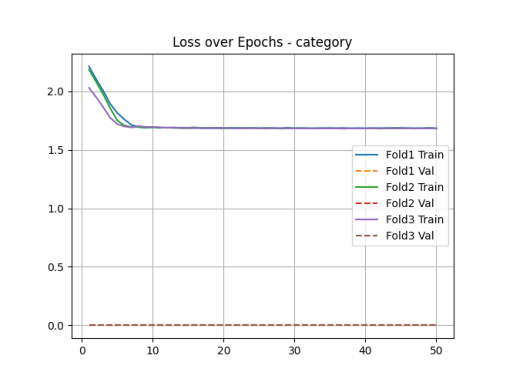

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category     precision         recall      f1-score           support
0      Community  52.83 ± 1.88  40.22 ± 14.23  44.59 ± 9.56  10866.67 ± 57.74
1  Entertainment  22.60 ± 1.83   40.26 ± 2.94  28.87 ± 1.36   5133.33 ± 57.74
2           Food  49.50 ± 6.77   34.53 ± 7.73  40.14 ± 5.21  22966.67 ± 57.74
3      Nightlife  18.07 ± 5.83   30.26 ± 2.34  22.07 ± 3.76   3633.33 ± 57.74
4       Outdoors  13.95 ± 5.08   23.78 ± 6.92  17.48 ± 5.63   1833.33 ± 57.74

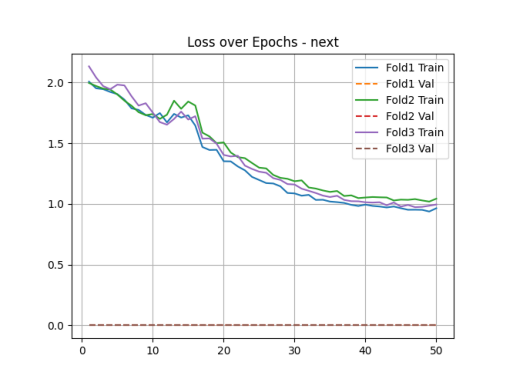

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

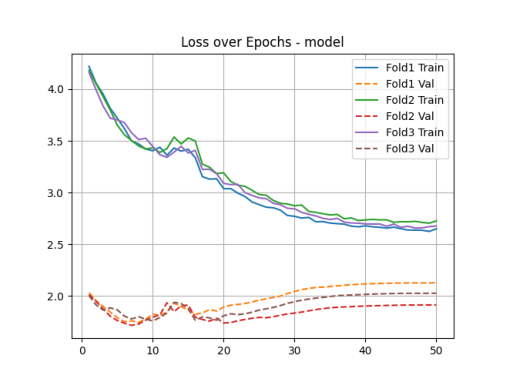

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# California

In [ ]:
ESTADO = "california"

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [ ]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [ ]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [ ]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


## HGI

In [ ]:
import os
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)


### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/poi_embedding.torch'

### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/filtrado.csv')

### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pois_gowalla.csv'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama//embeddings.csv


placeid         0         1         2         3         4         5  \
0         9531 -0.328018 -0.279717 -0.268858 -0.025124 -0.033602  0.831421   
1         9532 -0.212724 -0.188304 -0.040483 -0.244203  1.012444  1.173037   
2         9533  0.957083 -0.120902  0.103594 -0.226602  0.106776  0.596069   
3         9593 -0.033946  0.299042  0.101730 -0.204093  0.044489  0.653744   
4         9693  0.615521 -0.025080 -0.066807 -0.233809 -0.017595  0.547271   
...        ...       ...       ...       ...       ...       ...       ...   
10264  7565433 -0.317049 -0.118215 -0.024992 -0.075344 -0.097142  0.470303   
10265  7568997  0.111724 -0.083904  0.190910  0.032612 -0.245301  0.713871   
10266  7570992  0.049874 -0.004915 -0.391894  0.467625  0.852172  0.454604   
10267  7574223 -0.295706  0.242828 -0.606082 -0.171838  1.712261  0.892785   
10268  7574363 -0.160191 -0.025299 -0.118098 -0.441647  0.820836  0.780606   

              6         7         8  ...        55        56        57  \
0      0.487451  0.345670 -0.051999  ...  0.382835  0.569170  0.062280   
1     -0.368704 -0.216277  0.044884  ... -0.090151  0.303618  0.442501   
2     -0.405396  0.028514  0.509419  ... -0.079732  0.831397  0.024735   
3      0.662394  0.550874  0.672326  ... -0.085716  0.441036  0.209071   
4     -0.263094 -0.132398 -0.088840  ... -0.188026  1.086916 -0.036607   
...         ...       ...       ...  ...       ...       ...       ...   
10264  1.184643 -0.310203  0.385223  ...  1.237868 -0.138529  1.750363   
10265  1.140990 -0.011070 -0.039734  ...  0.244286 -0.005502  0.883621   
10266  0.777993  0.827893 -0.138480  ...  0.350916  0.725459 -0.101077   
10267  1.275130  0.676823  1.093236  ...  2.273987 -0.580897  1.323805   
10268 -0.135789  0.593972 -0.227308  ... -0.098488  0.860860  0.346416   

             58        59        60        61        62        63  \
0     -0.175719  0.631150 -0.055097  0.027944  0.636096  0.206160   
1     -0.290301  0.510194 -0.057238 -0.213825  0.169952  0.980230   
2     -0.035905  0.493928 -0.049237  1.114538 -0.022972  0.607717   
3      1.268344 -0.063430 -0.185252  0.540702  0.180796 -0.019045   
4     -0.170019  0.699518 -0.245074  0.281830 -0.058471  0.175323   
...         ...       ...       ...       ...       ...       ...   
10264 -0.187174  0.915760 -0.043957  0.691891  0.626277  0.029799   
10265 -0.288049  0.223249 -0.191501  0.471388 -0.290527  0.050230   
10266 -0.175795  1.246596  0.750474  0.479635 -0.163431 -0.023801   
10267  0.547652  2.097080 -0.205113  0.026762 -0.269167  0.473824   
10268 -0.206023 -0.031804 -0.141015  1.123400  0.464607 -0.099695   

            category  
0           Shopping  
1          Community  
2           Outdoors  
3             Travel  
4      Entertainment  
...              ...  
10264           Food  
10265       Shopping  
10266         Travel  
10267           Food  
10268       Shopping  

[10269 rows x 66 columns]

### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 200, Total visit sequences: 654
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 200/200 [00:00<00:00, 29576.93it/s]
nextpoi_sequences shape: (654, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/poi-sequences.csv

Generating next POI input data...
Resuming from row 654 (found existing file).
Batches: 0it [00:00, ?it/s]
Finished: wrote 654 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-06 12:36:40.877264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759754200.924851    8364 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759754200.938659    8364 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759754200.975348    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975407    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975417    8364 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251017_2100"

### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category     precision        recall      f1-score             support
0      Community  53.39 ± 1.71  29.47 ± 0.57  37.97 ± 0.14    658100.00 ± 0.00
1  Entertainment  54.50 ± 7.16  25.17 ± 1.93  34.24 ± 0.79   227366.67 ± 57.74
2           Food  58.91 ± 1.23  54.35 ± 3.05  56.48 ± 1.13  1704033.33 ± 57.74
3      Nightlife  61.77 ± 4.38  33.87 ± 0.47  43.73 ± 1.44   168666.67 ± 57.74
4       Outdoors  55.49 ± 2.66  24.75 ± 0.76  34.21 ± 0.37    320100.00 ± 0.00

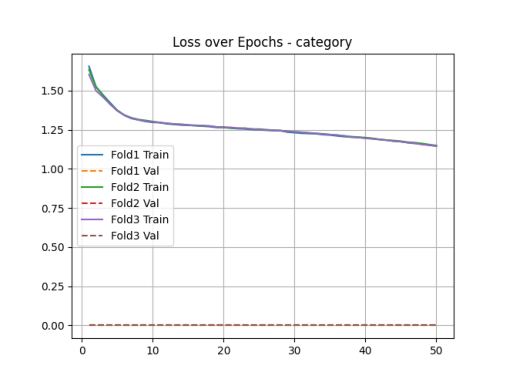

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category     precision        recall      f1-score  \
0      Community  33.14 ± 1.26  34.29 ± 2.87  33.62 ± 0.71   
1  Entertainment  18.31 ± 1.07  24.17 ± 2.50  20.80 ± 1.27   
2           Food  47.83 ± 0.81  21.54 ± 2.56  29.62 ± 2.23   
3      Nightlife  15.17 ± 0.54  38.69 ± 1.77  21.77 ± 0.28   
4       Outdoors  18.69 ± 2.30  31.71 ± 4.49  23.32 ± 1.29   

                 support  
0     729366.67 ± 611.01  
1     343500.00 ± 984.89  
2  1727600.00 ± 15062.20  
3    267033.33 ± 2285.46  
4    382000.00 ± 1646.21

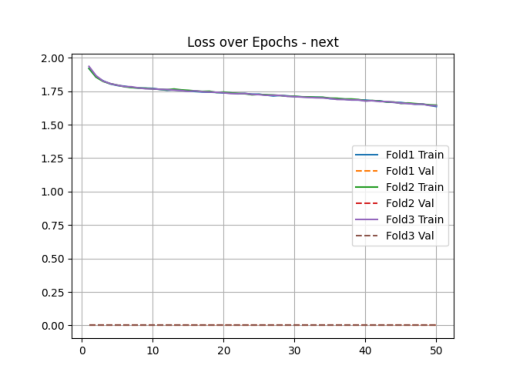

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

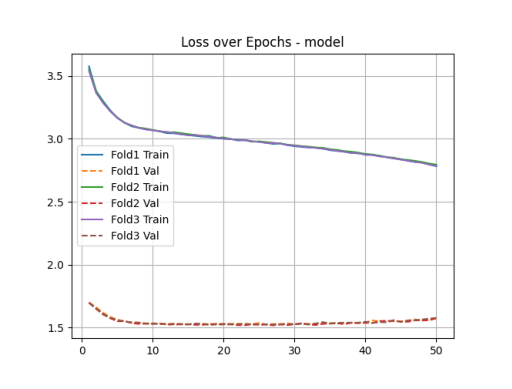

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# North Carolina

In [ ]:
ESTADO = "North Carolina"

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [ ]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [ ]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [ ]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


In [ ]:
pasta_output = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/"

## XGboost simples

In [ ]:
# !pip install xgboost scikit-learn pandas joblib --quiet

import json
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

CSV_PATH = f"{pasta_output}/location_encoder_embeddings.csv"
FEATURE_COLS = [str(i) for i in range(64)]
PLACE_COL = "placeid"
TARGET_COL = "category"
df = pd.read_csv(CSV_PATH)



df = df.dropna(subset=[TARGET_COL])
X = df[FEATURE_COLS].astype("float32").values
y_str = df[TARGET_COL].astype(str).values

le = LabelEncoder()
y = le.fit_transform(y_str)
n_classes = len(le.classes_)
print(f"Classes ({n_classes}):", list(le.classes_)[:10], "..." if n_classes>10 else "")

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = XGBClassifier(
    objective="multi:softprob",
    num_class=n_classes,
    n_estimators=800,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    eval_metric="mlogloss",
    random_state=42,
)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_tr)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_tr
)
print(class_weights)
sample_weights = np.array([class_weights[label] for label in y_tr], dtype=np.float32)

model.fit(
    X_tr, y_tr,
    sample_weight=sample_weights,
    eval_set=[(X_te, y_te)],
    verbose=False,

)


probs = model.predict_proba(X_te)
preds = np.argmax(probs, axis=1)

acc = accuracy_score(y_te, preds)
f1m = f1_score(y_te, preds, average="macro")
print(classification_report(y_te, preds, target_names=le.classes_, digits=4))

cm = confusion_matrix(y_te, preds)
print(cm)



Classes (7): ['Community', 'Entertainment', 'Food', 'Nightlife', 'Outdoors', 'Shopping', 'Travel'] 
[0.7596721  2.71189022 0.42689779 2.80960552 3.19195558 0.56950638
 1.82715471]
Accuracy: 0.2050 | Macro-F1: 0.1813

Relatório por classe:
               precision    recall  f1-score   support

    Community     0.2079    0.2164    0.2121      8622
Entertainment     0.0745    0.1159    0.0907      2415
         Food     0.3463    0.1828    0.2393     15343
    Nightlife     0.0539    0.1171    0.0738      2332
     Outdoors     0.0501    0.1491    0.0750      2052
     Shopping     0.2684    0.2168    0.2398     11501
       Travel     0.3025    0.3844    0.3385      3585

     accuracy                         0.2050     45850
    macro avg     0.1862    0.1975    0.1813     45850
 weighted avg     0.2549    0.2050    0.2185     45850

Confusion matrix (shape (7, 7) ):
 [[1866  675 1599 1031 1155 1749  547]
 [ 431  280  408  263  318  426  289]
 [2984 1266 2805 1710 2120 3255 1203]
 [ 4

## HGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/poi_embedding.torch'

### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_North Carolina.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/filtrado.csv')

### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/pois_gowalla.csv'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


[INFO] Cortando extras: 3267 -> 3266 feature_id (removidos 1).
Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina//embeddings.csv


placeid         0         1         2         3         4         5  \
0       9890 -0.008461 -0.009712  0.070281  0.021962 -0.002875 -0.000301   
1      10705  0.084380  0.015139  0.298696 -0.007346  0.267520  0.160951   
2      10972 -0.004029 -0.006037  0.132446  0.166919  0.111088 -0.021079   
3      10973 -0.005478 -0.005780  0.172590 -0.005627  0.132390 -0.010821   
4      10976 -0.003137 -0.006294  0.129097 -0.004536  0.017933 -0.012204   
...      ...       ...       ...       ...       ...       ...       ...   
3261  279553 -0.002399 -0.002478 -0.001849  0.078060  0.077673  0.066432   
3262  279654 -0.006616 -0.006267  0.025082  0.038279  0.016214  0.029202   
3263  279695  0.039526  0.209739 -0.001001 -0.008441 -0.001573  0.044118   
3264  279768  0.178235 -0.002850  0.118267 -0.002765 -0.000676 -0.003559   
3265  279861  0.039301 -0.003311  0.061546  0.013384  0.094271 -0.004146   

             6         7         8  ...        55        56        57  \
0    -0.027653  0.245472  0.038063  ...  0.259615  0.162322 -0.003880   
1     0.415434  0.075092  0.059293  ... -0.003507  0.110061 -0.000595   
2     0.104334  0.030975 -0.018731  ... -0.001290  0.044746  0.138374   
3     0.033413  0.124850 -0.018942  ...  0.011629  0.022415  0.097308   
4     0.065405  0.052245 -0.017157  ... -0.001612  0.062032  0.174669   
...        ...       ...       ...  ...       ...       ...       ...   
3261 -0.003589 -0.004119 -0.008175  ...  0.204112  0.220314  0.028441   
3262 -0.011532  0.112473 -0.002053  ...  0.208332  0.007824  0.023832   
3263 -0.005262  0.055862  0.044748  ...  0.141418  0.080295 -0.004907   
3264 -0.002714  0.062999  0.038943  ... -0.000654 -0.000665 -0.008548   
3265  0.063558 -0.005367 -0.011252  ... -0.003956  0.036465 -0.002599   

            58        59        60        61        62        63  \
0     0.128119 -0.005006  0.244185  0.079929  0.003111  0.103239   
1     0.202233  0.134472  0.160549 -0.002342 -0.000841  0.118212   
2    -0.016010 -0.001807 -0.006183  0.167200  0.340393  0.008615   
3    -0.014695  0.049432 -0.005306  0.058556  0.313487  0.150222   
4    -0.010369  0.053094  0.031854  0.018853  0.342746  0.118765   
...        ...       ...       ...       ...       ...       ...   
3261  0.102314  0.038630  0.226166 -0.002961 -0.008155  0.011416   
3262  0.033552  0.040953  0.265327 -0.009311 -0.008765  0.022205   
3263  0.054186  0.033167  0.077162 -0.002477  0.025481 -0.001703   
3264  0.001375  0.034130 -0.005839 -0.007074 -0.002157  0.002052   
3265  0.001171 -0.001397  0.051854  0.029844  0.161598  0.079661   

           category  
0     Entertainment  
1     Entertainment  
2     Entertainment  
3          Outdoors  
4          Outdoors  
...             ...  
3261           Food  
3262           Food  
3263       Shopping  
3264       Shopping  
3265           Food  

[3266 rows x 66 columns]

### Treino com novo modelo de embeddings pelo HGI

In [ ]:
state = ESTADO
!python -m pipelines.create_inputs "{state}"

Generating sequences for each user...
Users with valid sequences: 3311, Total visit sequences: 25572
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 3311/3311 [00:00<00:00, 37610.10it/s]
nextpoi_sequences shape: (25572, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 3/3 [00:10<00:00,  3.39s/it, rows_written=25572]
Finished: wrote 25572 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/pre-processing/next-input.csv
Processing complete!


In [ ]:
state = ESTADO

!python -m pipelines.mtlnet_trainer "{state}"

2025-11-02 13:40:46.535073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762090846.567792    1662 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762090846.577842    1662 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762090846.602705    1662 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762090846.602736    1662 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762090846.602744    1662 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251006_1236"

### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category      precision        recall      f1-score           support
0      Community  64.08 ± 14.18  66.26 ± 8.50  64.53 ± 9.53   3266.67 ± 57.74
1  Entertainment  47.29 ± 18.12  19.37 ± 0.55  26.92 ± 3.10   2066.67 ± 57.74
2           Food   71.58 ± 3.02  76.38 ± 5.53  73.78 ± 2.55  13966.67 ± 57.74
3      Nightlife   57.85 ± 7.62  54.76 ± 5.46  55.84 ± 2.63    2800.00 ± 0.00
4       Outdoors   67.92 ± 9.16  69.19 ± 3.08  68.28 ± 4.81   3133.33 ± 57.74

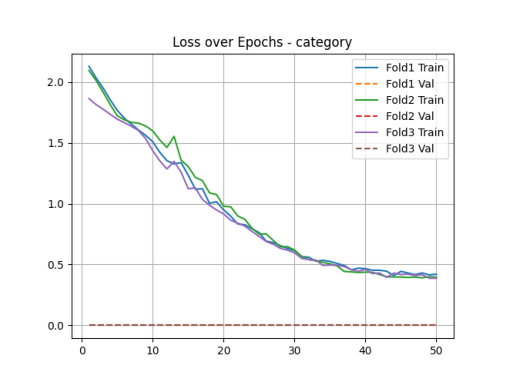

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score          support
0      Community   53.78 ± 2.75  75.65 ± 10.08   62.55 ± 2.40  4366.67 ± 57.74
1  Entertainment   18.84 ± 4.09   23.21 ± 9.28   20.62 ± 6.35   733.33 ± 57.74
2           Food   41.92 ± 8.34  12.22 ± 10.84  16.87 ± 13.45   6000.00 ± 0.00
3      Nightlife  34.44 ± 15.03   24.36 ± 8.41   26.27 ± 4.81  1233.33 ± 57.74
4       Outdoors   32.06 ± 7.78  54.03 ± 18.45   39.60 ± 9.67  1533.33 ± 57.74

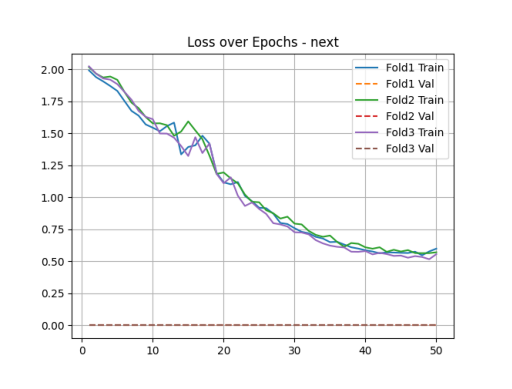

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

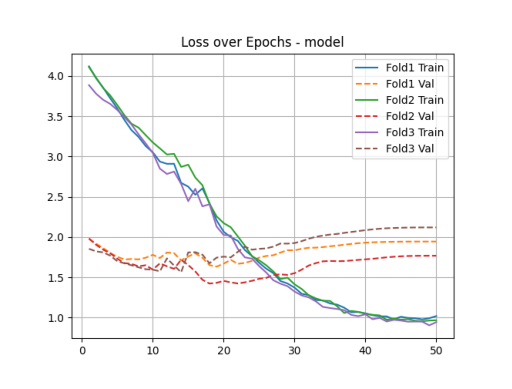

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## DGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

## POI Embedding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [ ]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [ ]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.title()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.title()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_North Carolina.csv')

#### pois_gowalla

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/pois_gowalla.csv'

#### poi-encoder-gowalla-h3.tensor

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"poi-encoder-gowalla-h3.tensor")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi-encoder-gowalla-h3.tensor")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/poi-encoder-gowalla-h3.tensor'

In [ ]:
!pip install torch

In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install -q --extra-index-url https://download.pytorch.org/whl/cu121 \
  torch torchvision torchaudio


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import sys
import numpy as np
import pandas as pd
import torch

pois_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/pois_gowalla.csv")
tensor_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/poi-encoder-gowalla-h3.tensor")
filtrado_path = Path(f"{diretorio_principal}/data/checkins/checkins_{ESTADO.title()}.csv")

def load_embedding_matrix(tensor_path: str, key: str = "in_embed.weight") -> np.ndarray:
    """
    Carrega o .tensor (checkpoint PyTorch) e retorna um numpy array (num_fclass, emb_dim).
    """
    ckpt = torch.load(tensor_path, map_location="cpu")
    if key not in ckpt:
        raise KeyError(f"Chave '{key}' não encontrada no arquivo '{tensor_path}'. "
                       f"Chaves disponíveis: {list(ckpt.keys())[:10]}...")
    W = ckpt[key]
    if not isinstance(W, torch.Tensor):
        raise TypeError(f"Valor em '{key}' não é um torch.Tensor (veio {type(W)}).")
    if W.ndim != 2:
        raise ValueError(f"Esperado tensor 2D em '{key}', mas veio shape {tuple(W.shape)}.")
    return W.detach().cpu().numpy()


def build_output_df(pois_path: str, W: np.ndarray, filtrado_path: str) -> pd.DataFrame:
    """
    Gera o DataFrame final com:
      - placeid (copiado de feature_id)
      - emb_0 ... emb_(D-1) mapeados por fclass
      - category (join com filtrado.csv via placeid)
    """
    pois = pd.read_csv(pois_path)
    if "feature_id" not in pois.columns or "fclass" not in pois.columns:
        raise KeyError("O arquivo pois_gowalla.csv deve conter as colunas 'feature_id' e 'fclass'. "
                       f"Colunas encontradas: {list(pois.columns)}")

    pois["feature_id"] = pois["feature_id"].astype(str)
    try:
        pois["fclass"] = pois["fclass"].astype(int)
    except Exception as e:
        raise ValueError("Falha ao converter 'fclass' para int. "
                         "Verifique se há valores não numéricos.") from e

    num_classes, emb_dim = W.shape

    n = len(pois)
    emb = np.full((n, emb_dim), np.nan, dtype=float)

    valid = (pois["fclass"] >= 0) & (pois["fclass"] < num_classes)
    if not valid.all():
        invalid_rows = (~valid).sum()

    emb[valid.values] = W[pois.loc[valid, "fclass"].to_numpy()]

    emb_cols = [f"{i}" for i in range(emb_dim)]
    out = pd.DataFrame(emb, columns=emb_cols)
    out.insert(0, "placeid", pois["feature_id"].astype(str))

    filtrado = pd.read_csv(filtrado_path)

    if "placeid" not in filtrado.columns:
        if "feature_id" in filtrado.columns:
            filtrado = filtrado.rename(columns={"feature_id": "placeid"})
        else:
            raise KeyError("O arquivo filtrado.csv deve conter a coluna 'placeid'. "
                           f"Colunas encontradas: {list(filtrado.columns)}")

    if "category" not in filtrado.columns:
        raise KeyError("O arquivo filtrado.csv deve conter a coluna 'category'.")

    filtrado["placeid"] = filtrado["placeid"].astype(str)

    out = out.merge(filtrado[["placeid", "category"]], on="placeid", how="left")



    return out



In [ ]:
W =load_embedding_matrix(tensor_path)
out_df = build_output_df(pois_path, W, filtrado_path)


In [ ]:
pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
out_df.to_csv(f"{pasta_output}/embeddings-poi-encoder.csv", index=False)


### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

usage: create_inputs.py [-h] state_name
create_inputs.py: error: unrecognized arguments: Carolina


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-31 03:08:30.778887: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 03:08:30.796568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761880110.818348    7295 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761880110.825583    7295 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761880110.844096    7295 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251031_0308"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category     precision        recall      f1-score           support
0      Community   0.00 ± 0.00   0.00 ± 0.00   0.00 ± 0.00   11400.00 ± 0.00
1  Entertainment   0.00 ± 0.00   0.00 ± 0.00   0.00 ± 0.00   6166.67 ± 57.74
2           Food  36.59 ± 0.21  97.46 ± 0.89  53.20 ± 0.34  34066.67 ± 57.74
3      Nightlife   0.00 ± 0.00   0.00 ± 0.00   0.00 ± 0.00   7566.67 ± 57.74
4       Outdoors   0.00 ± 0.00   0.00 ± 0.00   0.00 ± 0.00   4666.67 ± 57.74

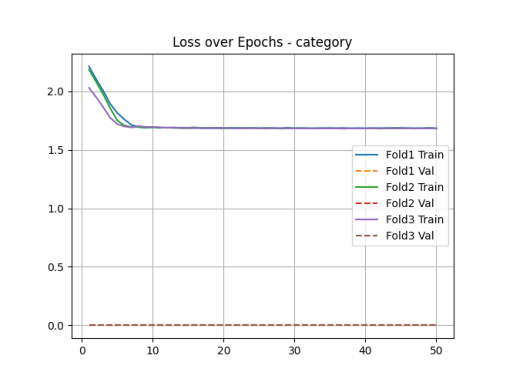

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category     precision         recall      f1-score           support
0      Community  52.83 ± 1.88  40.22 ± 14.23  44.59 ± 9.56  10866.67 ± 57.74
1  Entertainment  22.60 ± 1.83   40.26 ± 2.94  28.87 ± 1.36   5133.33 ± 57.74
2           Food  49.50 ± 6.77   34.53 ± 7.73  40.14 ± 5.21  22966.67 ± 57.74
3      Nightlife  18.07 ± 5.83   30.26 ± 2.34  22.07 ± 3.76   3633.33 ± 57.74
4       Outdoors  13.95 ± 5.08   23.78 ± 6.92  17.48 ± 5.63   1833.33 ± 57.74

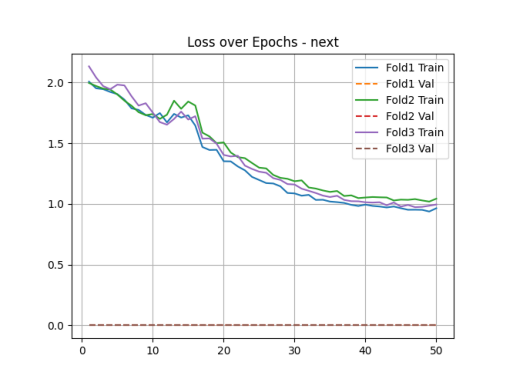

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

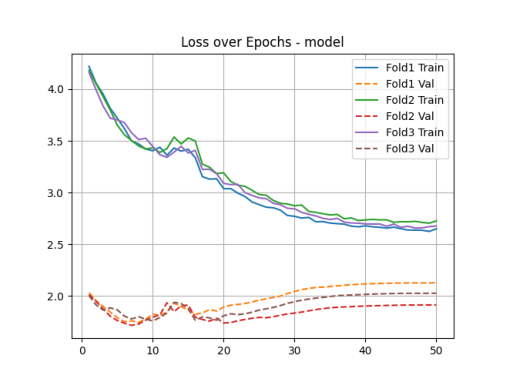

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# Texas

In [ ]:
ESTADO = "texas"

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [ ]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [ ]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [ ]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


In [ ]:
import os
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)


## HGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/texas/poi_embedding.torch'

### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/texas/filtrado.csv')

### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/texas/pois_gowalla.csv'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/texas//embeddings.csv


placeid         0         1         2         3         4         5  \
0         8932  0.084892 -0.001164  0.023526 -0.002701  0.208711  0.094718   
1         8956  0.299008  0.191928  0.006764 -0.001994  0.007055  0.121224   
2         8957  0.164421 -0.000655  0.144950 -0.005450  0.156834 -0.002534   
3         8982 -0.003203  0.007942  0.204291  0.076490 -0.003374  0.101367   
4         8988  0.097795  0.000247  0.007133 -0.002131  0.153966 -0.003158   
...        ...       ...       ...       ...       ...       ...       ...   
95580  4112643 -0.001374  0.086724  0.067913 -0.001972  0.206394  0.041150   
95581  4112852  0.068037  0.000478  0.073801  0.009532 -0.002830 -0.005560   
95582  4113248  0.077806 -0.000308  0.037348  0.091544  0.011080  0.032662   
95583  4113457  0.069676  0.047117  0.038373 -0.000597  0.014630  0.011780   
95584  4113501  0.045021  0.098385  0.135193  0.239613 -0.003041 -0.000371   

              6         7         8  ...        55        56        57  \
0     -0.011186 -0.001605  0.167812  ... -0.001187  0.182324 -0.000388   
1     -0.003083  0.115240 -0.003985  ...  0.365565  0.121406 -0.000316   
2      0.033658 -0.001056  0.123433  ... -0.001337 -0.001506  0.114029   
3     -0.002297  0.114109  0.060163  ...  0.338070  0.027156  0.028498   
4      0.158959 -0.004332 -0.004429  ...  0.119250 -0.000618 -0.005105   
...         ...       ...       ...  ...       ...       ...       ...   
95580  0.011465 -0.000488  0.123424  ...  0.227293  0.082824 -0.001769   
95581 -0.001076  0.045324 -0.000079  ...  0.425524  0.004133  0.019941   
95582 -0.000097  0.045207  0.110936  ...  0.202122  0.069694  0.000352   
95583 -0.002666 -0.000374 -0.002424  ...  0.109980 -0.000609 -0.002086   
95584 -0.000978 -0.001359 -0.001245  ...  0.165376  0.099993  0.012880   

             58        59        60        61        62        63   category  
0     -0.006109  0.150966  0.192428  0.126987  0.130890 -0.004018       Food  
1     -0.000961  0.093550 -0.002940 -0.001370  0.099218 -0.001775  Community  
2     -0.000790  0.127502 -0.001996 -0.000976 -0.003321  0.232508   Outdoors  
3     -0.001225 -0.001747  0.073415  0.137575 -0.004435  0.066886       Food  
4      0.148009  0.198744 -0.008643  0.057463 -0.001151  0.020038       Food  
...         ...       ...       ...       ...       ...       ...        ...  
95580 -0.000881  0.029716 -0.002894 -0.004819  0.021608  0.164235   Shopping  
95581 -0.001515  0.084174  0.075039  0.111344  0.075831  0.083028   Shopping  
95582 -0.000810  0.034192  0.062613  0.091374  0.013334  0.009570       Food  
95583 -0.000081 -0.002272  0.085586  0.004839  0.024289  0.057873       Food  
95584  0.106095  0.004424  0.058968  0.116166  0.192212  0.041839  Community  

[95585 rows x 66 columns]

### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 12520, Total visit sequences: 112259
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 12520/12520 [00:00<00:00, 21135.53it/s]
nextpoi_sequences shape: (112259, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 12/12 [00:59<00:00,  4.94s/it, rows_written=112259]
Finished: wrote 112259 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-11-03 02:33:32.525874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762137212.765740    4163 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762137212.831574    4163 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762137213.299655    4163 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762137213.299693    4163 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762137213.299699    4163 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251006_1236"

### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category      precision        recall      f1-score           support
0      Community  64.08 ± 14.18  66.26 ± 8.50  64.53 ± 9.53   3266.67 ± 57.74
1  Entertainment  47.29 ± 18.12  19.37 ± 0.55  26.92 ± 3.10   2066.67 ± 57.74
2           Food   71.58 ± 3.02  76.38 ± 5.53  73.78 ± 2.55  13966.67 ± 57.74
3      Nightlife   57.85 ± 7.62  54.76 ± 5.46  55.84 ± 2.63    2800.00 ± 0.00
4       Outdoors   67.92 ± 9.16  69.19 ± 3.08  68.28 ± 4.81   3133.33 ± 57.74

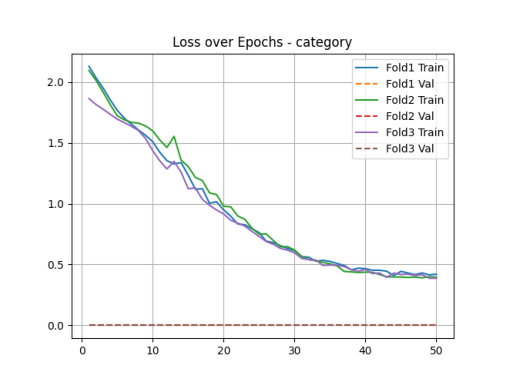

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score          support
0      Community   53.78 ± 2.75  75.65 ± 10.08   62.55 ± 2.40  4366.67 ± 57.74
1  Entertainment   18.84 ± 4.09   23.21 ± 9.28   20.62 ± 6.35   733.33 ± 57.74
2           Food   41.92 ± 8.34  12.22 ± 10.84  16.87 ± 13.45   6000.00 ± 0.00
3      Nightlife  34.44 ± 15.03   24.36 ± 8.41   26.27 ± 4.81  1233.33 ± 57.74
4       Outdoors   32.06 ± 7.78  54.03 ± 18.45   39.60 ± 9.67  1533.33 ± 57.74

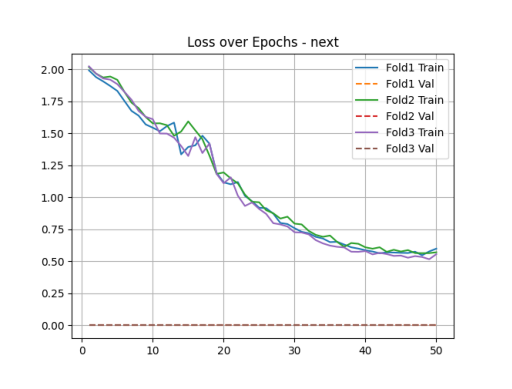

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

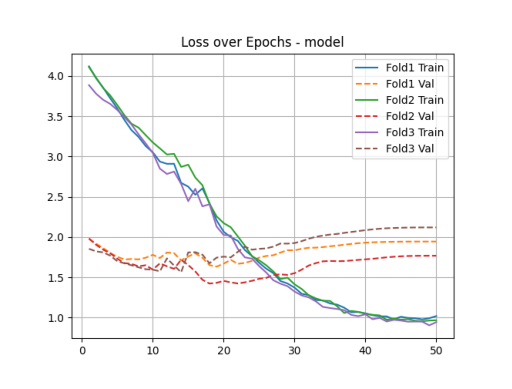

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## POI Embedding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [ ]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [ ]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_Texas.csv')

#### pois_gowalla

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/texas/pois_gowalla.csv'

#### poi-encoder-gowalla-h3.tensor

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"poi-encoder-gowalla-h3_texas.tensor")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi-encoder-gowalla-h3.tensor")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/texas/poi-encoder-gowalla-h3.tensor'

In [ ]:
import sys
import numpy as np
import pandas as pd
import torch

pois_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/pois_gowalla.csv")
tensor_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/poi-encoder-gowalla-h3.tensor")
filtrado_path = Path(f"{diretorio_principal}/data/checkins/checkins_{ESTADO.capitalize()}.csv")

def load_embedding_matrix(tensor_path: str, key: str = "in_embed_texas.weight") -> np.ndarray:
    """
    Carrega o .tensor (checkpoint PyTorch) e retorna um numpy array (num_fclass, emb_dim).
    """
    ckpt = torch.load(tensor_path, map_location="cpu")
    if key not in ckpt:
        raise KeyError(f"Chave '{key}' não encontrada no arquivo '{tensor_path}'. "
                       f"Chaves disponíveis: {list(ckpt.keys())[:10]}...")
    W = ckpt[key]
    if not isinstance(W, torch.Tensor):
        raise TypeError(f"Valor em '{key}' não é um torch.Tensor (veio {type(W)}).")
    if W.ndim != 2:
        raise ValueError(f"Esperado tensor 2D em '{key}', mas veio shape {tuple(W.shape)}.")
    return W.detach().cpu().numpy()


def build_output_df(pois_path: str, W: np.ndarray, filtrado_path: str) -> pd.DataFrame:
    """
    Gera o DataFrame final com:
      - placeid (copiado de feature_id)
      - emb_0 ... emb_(D-1) mapeados por fclass
      - category (join com filtrado.csv via placeid)
    """
    pois = pd.read_csv(pois_path)
    if "feature_id" not in pois.columns or "fclass" not in pois.columns:
        raise KeyError("O arquivo pois_gowalla.csv deve conter as colunas 'feature_id' e 'fclass'. "
                       f"Colunas encontradas: {list(pois.columns)}")

    pois["feature_id"] = pois["feature_id"].astype(str)
    try:
        pois["fclass"] = pois["fclass"].astype(int)
    except Exception as e:
        raise ValueError("Falha ao converter 'fclass' para int. "
                         "Verifique se há valores não numéricos.") from e

    num_classes, emb_dim = W.shape

    n = len(pois)
    emb = np.full((n, emb_dim), np.nan, dtype=float)

    valid = (pois["fclass"] >= 0) & (pois["fclass"] < num_classes)
    if not valid.all():
        invalid_rows = (~valid).sum()

    emb[valid.values] = W[pois.loc[valid, "fclass"].to_numpy()]

    emb_cols = [f"{i}" for i in range(emb_dim)]
    out = pd.DataFrame(emb, columns=emb_cols)
    out.insert(0, "placeid", pois["feature_id"].astype(str))

    filtrado = pd.read_csv(filtrado_path)

    if "placeid" not in filtrado.columns:
        if "feature_id" in filtrado.columns:
            filtrado = filtrado.rename(columns={"feature_id": "placeid"})
        else:
            raise KeyError("O arquivo filtrado.csv deve conter a coluna 'placeid'. "
                           f"Colunas encontradas: {list(filtrado.columns)}")

    if "category" not in filtrado.columns:
        raise KeyError("O arquivo filtrado.csv deve conter a coluna 'category'.")

    filtrado["placeid"] = filtrado["placeid"].astype(str)

    out = out.merge(filtrado[["placeid", "category"]], on="placeid", how="left")



    return out



In [ ]:
W =load_embedding_matrix(tensor_path)
out_df = build_output_df(pois_path, W, filtrado_path)


In [ ]:
pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
out_df.to_csv(f"{pasta_output}/embeddings-poi-encoder.csv", index=False)


### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 26266, Total visit sequences: 378783
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 26266/26266 [00:01<00:00, 19406.28it/s]
nextpoi_sequences shape: (378783, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/texas/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/texas/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 38/38 [02:37<00:00,  4.13s/it, rows_written=378783]
Finished: wrote 378783 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/texas/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-11-03 17:24:57.452488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762190697.472258    5751 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762190697.478552    5751 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762190697.499026    5751 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762190697.499082    5751 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762190697.499084    5751 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251024_1257"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score  \
0      Community  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
1  Entertainment  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
2           Food  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
3      Nightlife  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
4       Outdoors  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   

                 support  
0    521400.00 ± 5864.30  
1    356600.00 ± 5350.70  
2  1126400.00 ± 10016.49  
3    227233.33 ± 3611.56  
4    244800.00 ± 7547.85

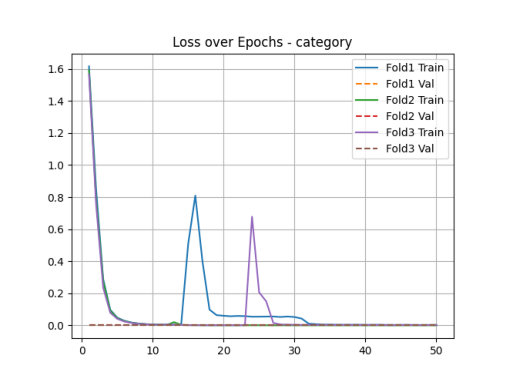

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category     precision        recall      f1-score             support
0      Community  34.66 ± 1.81  52.64 ± 3.86  41.70 ± 0.24    484500.00 ± 0.00
1  Entertainment  31.59 ± 2.29  33.95 ± 4.21  32.52 ± 0.64    332700.00 ± 0.00
2           Food  45.85 ± 1.15  22.36 ± 4.85  29.80 ± 4.31  1076833.33 ± 57.74
3      Nightlife  20.98 ± 0.21  34.03 ± 4.38  25.90 ± 1.47   214633.33 ± 57.74
4       Outdoors  18.65 ± 0.43  29.57 ± 4.08  22.79 ± 0.90   232433.33 ± 57.74

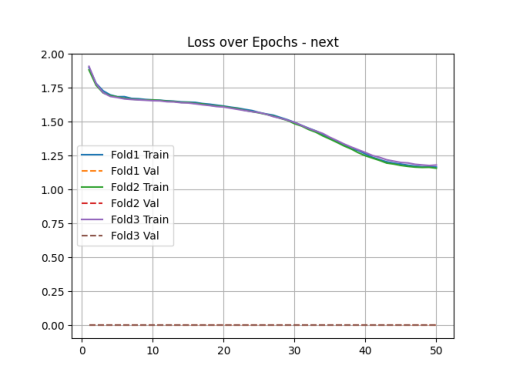

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

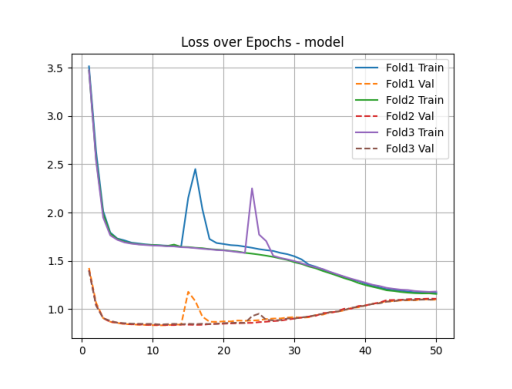

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# California

In [ ]:
ESTADO = "california"

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [ ]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [ ]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [ ]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


In [ ]:
import os
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)


## HGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/california/poi_embedding.torch'

### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/california/filtrado.csv')

### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/california/pois_gowalla.csv'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


[INFO] Cortando extras: 109508 -> 95585 feature_id (removidos 13923).
Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/california//embeddings.csv


placeid         0         1         2         3         4         5  \
0         8947  0.084892 -0.001164  0.023526 -0.002701  0.208711  0.094718   
1         9060  0.299008  0.191928  0.006764 -0.001994  0.007055  0.121224   
2         9062  0.164421 -0.000655  0.144950 -0.005450  0.156834 -0.002534   
3         9063 -0.003203  0.007942  0.204291  0.076490 -0.003374  0.101367   
4         9064  0.097795  0.000247  0.007133 -0.002131  0.153966 -0.003158   
...        ...       ...       ...       ...       ...       ...       ...   
95580  1403202 -0.001374  0.086724  0.067913 -0.001972  0.206394  0.041150   
95581  1403227  0.068037  0.000478  0.073801  0.009532 -0.002830 -0.005560   
95582  1403234  0.077806 -0.000308  0.037348  0.091544  0.011080  0.032662   
95583  1403242  0.069676  0.047117  0.038373 -0.000597  0.014630  0.011780   
95584  1403288  0.045021  0.098385  0.135193  0.239613 -0.003041 -0.000371   

              6         7         8  ...        55        56        57  \
0     -0.011186 -0.001605  0.167812  ... -0.001187  0.182324 -0.000388   
1     -0.003083  0.115240 -0.003985  ...  0.365565  0.121406 -0.000316   
2      0.033658 -0.001056  0.123433  ... -0.001337 -0.001506  0.114029   
3     -0.002297  0.114109  0.060163  ...  0.338070  0.027156  0.028498   
4      0.158959 -0.004332 -0.004429  ...  0.119250 -0.000618 -0.005105   
...         ...       ...       ...  ...       ...       ...       ...   
95580  0.011465 -0.000488  0.123424  ...  0.227293  0.082824 -0.001769   
95581 -0.001076  0.045324 -0.000079  ...  0.425524  0.004133  0.019941   
95582 -0.000097  0.045207  0.110936  ...  0.202122  0.069694  0.000352   
95583 -0.002666 -0.000374 -0.002424  ...  0.109980 -0.000609 -0.002086   
95584 -0.000978 -0.001359 -0.001245  ...  0.165376  0.099993  0.012880   

             58        59        60        61        62        63   category  
0     -0.006109  0.150966  0.192428  0.126987  0.130890 -0.004018  Community  
1     -0.000961  0.093550 -0.002940 -0.001370  0.099218 -0.001775   Outdoors  
2     -0.000790  0.127502 -0.001996 -0.000976 -0.003321  0.232508  Community  
3     -0.001225 -0.001747  0.073415  0.137575 -0.004435  0.066886  Community  
4      0.148009  0.198744 -0.008643  0.057463 -0.001151  0.020038   Outdoors  
...         ...       ...       ...       ...       ...       ...        ...  
95580 -0.000881  0.029716 -0.002894 -0.004819  0.021608  0.164235   Shopping  
95581 -0.001515  0.084174  0.075039  0.111344  0.075831  0.083028  Community  
95582 -0.000810  0.034192  0.062613  0.091374  0.013334  0.009570       Food  
95583 -0.000081 -0.002272  0.085586  0.004839  0.024289  0.057873  Community  
95584  0.106095  0.004424  0.058968  0.116166  0.192212  0.041839       Food  

[95585 rows x 66 columns]

### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 12520, Total visit sequences: 112259
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 12520/12520 [00:00<00:00, 21135.53it/s]
nextpoi_sequences shape: (112259, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 12/12 [00:59<00:00,  4.94s/it, rows_written=112259]
Finished: wrote 112259 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-11-03 02:33:32.525874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762137212.765740    4163 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762137212.831574    4163 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762137213.299655    4163 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762137213.299693    4163 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762137213.299699    4163 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251006_1236"

### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category      precision        recall      f1-score           support
0      Community  64.08 ± 14.18  66.26 ± 8.50  64.53 ± 9.53   3266.67 ± 57.74
1  Entertainment  47.29 ± 18.12  19.37 ± 0.55  26.92 ± 3.10   2066.67 ± 57.74
2           Food   71.58 ± 3.02  76.38 ± 5.53  73.78 ± 2.55  13966.67 ± 57.74
3      Nightlife   57.85 ± 7.62  54.76 ± 5.46  55.84 ± 2.63    2800.00 ± 0.00
4       Outdoors   67.92 ± 9.16  69.19 ± 3.08  68.28 ± 4.81   3133.33 ± 57.74

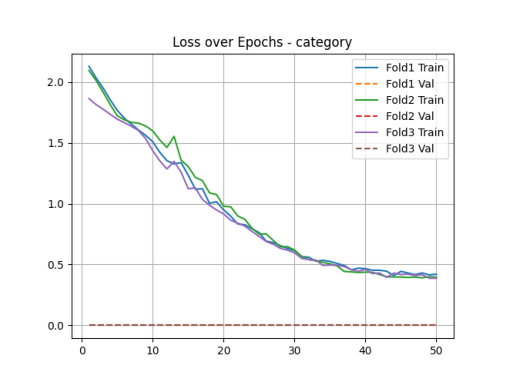

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score          support
0      Community   53.78 ± 2.75  75.65 ± 10.08   62.55 ± 2.40  4366.67 ± 57.74
1  Entertainment   18.84 ± 4.09   23.21 ± 9.28   20.62 ± 6.35   733.33 ± 57.74
2           Food   41.92 ± 8.34  12.22 ± 10.84  16.87 ± 13.45   6000.00 ± 0.00
3      Nightlife  34.44 ± 15.03   24.36 ± 8.41   26.27 ± 4.81  1233.33 ± 57.74
4       Outdoors   32.06 ± 7.78  54.03 ± 18.45   39.60 ± 9.67  1533.33 ± 57.74

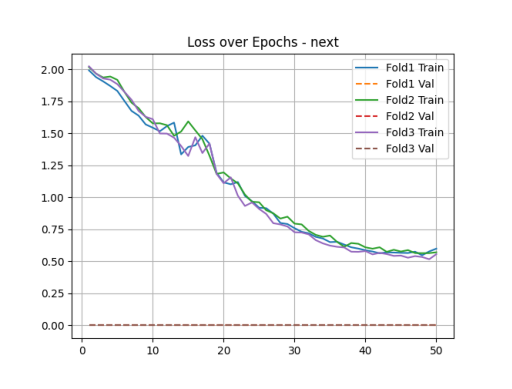

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

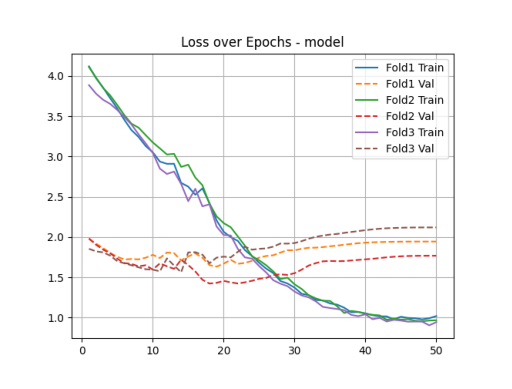

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## POI Embedding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [ ]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [ ]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_California.csv')

#### pois_gowalla

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/texas/pois_gowalla.csv'

#### poi-encoder-gowalla-h3.tensor

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"poi-encoder-gowalla-h3_california.tensor")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi-encoder-gowalla-h3.tensor")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/california/poi-encoder-gowalla-h3.tensor'

In [ ]:
import sys
import numpy as np
import pandas as pd
import torch

pois_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/pois_gowalla.csv")
tensor_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/poi-encoder-gowalla-h3.tensor")
filtrado_path = Path(f"{diretorio_principal}/data/checkins/checkins_{ESTADO.capitalize()}.csv")

def load_embedding_matrix(tensor_path: str, key: str = "in_embed_california.weight") -> np.ndarray:
    """
    Carrega o .tensor (checkpoint PyTorch) e retorna um numpy array (num_fclass, emb_dim).
    """
    ckpt = torch.load(tensor_path, map_location="cpu")
    if key not in ckpt:
        raise KeyError(f"Chave '{key}' não encontrada no arquivo '{tensor_path}'. "
                       f"Chaves disponíveis: {list(ckpt.keys())[:10]}...")
    W = ckpt[key]
    if not isinstance(W, torch.Tensor):
        raise TypeError(f"Valor em '{key}' não é um torch.Tensor (veio {type(W)}).")
    if W.ndim != 2:
        raise ValueError(f"Esperado tensor 2D em '{key}', mas veio shape {tuple(W.shape)}.")
    return W.detach().cpu().numpy()


def build_output_df(pois_path: str, W: np.ndarray, filtrado_path: str) -> pd.DataFrame:
    """
    Gera o DataFrame final com:
      - placeid (copiado de feature_id)
      - emb_0 ... emb_(D-1) mapeados por fclass
      - category (join com filtrado.csv via placeid)
    """
    pois = pd.read_csv(pois_path)
    if "feature_id" not in pois.columns or "fclass" not in pois.columns:
        raise KeyError("O arquivo pois_gowalla.csv deve conter as colunas 'feature_id' e 'fclass'. "
                       f"Colunas encontradas: {list(pois.columns)}")

    pois["feature_id"] = pois["feature_id"].astype(str)
    try:
        pois["fclass"] = pois["fclass"].astype(int)
    except Exception as e:
        raise ValueError("Falha ao converter 'fclass' para int. "
                         "Verifique se há valores não numéricos.") from e

    num_classes, emb_dim = W.shape

    n = len(pois)
    emb = np.full((n, emb_dim), np.nan, dtype=float)

    valid = (pois["fclass"] >= 0) & (pois["fclass"] < num_classes)
    if not valid.all():
        invalid_rows = (~valid).sum()

    emb[valid.values] = W[pois.loc[valid, "fclass"].to_numpy()]

    emb_cols = [f"{i}" for i in range(emb_dim)]
    out = pd.DataFrame(emb, columns=emb_cols)
    out.insert(0, "placeid", pois["feature_id"].astype(str))

    filtrado = pd.read_csv(filtrado_path)

    if "placeid" not in filtrado.columns:
        if "feature_id" in filtrado.columns:
            filtrado = filtrado.rename(columns={"feature_id": "placeid"})
        else:
            raise KeyError("O arquivo filtrado.csv deve conter a coluna 'placeid'. "
                           f"Colunas encontradas: {list(filtrado.columns)}")

    if "category" not in filtrado.columns:
        raise KeyError("O arquivo filtrado.csv deve conter a coluna 'category'.")

    filtrado["placeid"] = filtrado["placeid"].astype(str)

    out = out.merge(filtrado[["placeid", "category"]], on="placeid", how="left")



    return out



In [ ]:
W =load_embedding_matrix(tensor_path)
out_df = build_output_df(pois_path, W, filtrado_path)


In [ ]:
pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
out_df.to_csv(f"{pasta_output}/embeddings-poi-encoder.csv", index=False)


### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 24507, Total visit sequences: 286876
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 24507/24507 [00:00<00:00, 26095.31it/s]
nextpoi_sequences shape: (286876, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/california/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/california/pre-processing/next-input.csv
Resuming from row 286876 (found existing file).
Batches: 0it [00:00, ?it/s]
Finished: wrote 286876 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/california/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-11-04 12:07:33.140473: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-04 12:07:33.157411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762258053.178434    2430 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762258053.184852    2430 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762258053.200983    2430 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251024_1257"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score  \
0      Community  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
1  Entertainment  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
2           Food  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
3      Nightlife  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
4       Outdoors  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   

                 support  
0    521400.00 ± 5864.30  
1    356600.00 ± 5350.70  
2  1126400.00 ± 10016.49  
3    227233.33 ± 3611.56  
4    244800.00 ± 7547.85

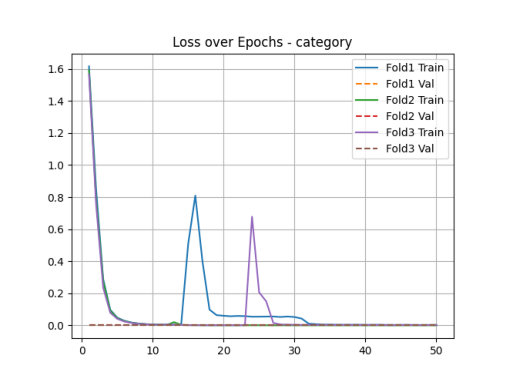

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category     precision        recall      f1-score             support
0      Community  34.66 ± 1.81  52.64 ± 3.86  41.70 ± 0.24    484500.00 ± 0.00
1  Entertainment  31.59 ± 2.29  33.95 ± 4.21  32.52 ± 0.64    332700.00 ± 0.00
2           Food  45.85 ± 1.15  22.36 ± 4.85  29.80 ± 4.31  1076833.33 ± 57.74
3      Nightlife  20.98 ± 0.21  34.03 ± 4.38  25.90 ± 1.47   214633.33 ± 57.74
4       Outdoors  18.65 ± 0.43  29.57 ± 4.08  22.79 ± 0.90   232433.33 ± 57.74

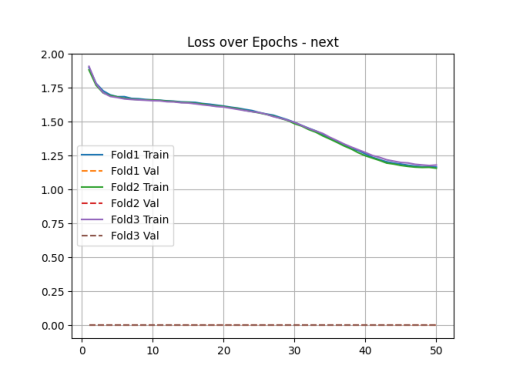

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

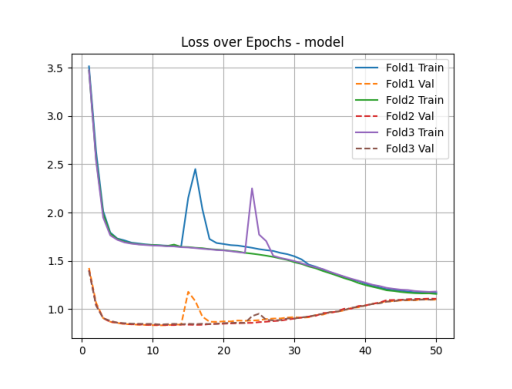

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# Montana

In [ ]:
ESTADO = "montana"

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [ ]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [ ]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [ ]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


In [ ]:
import os
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)


## HGI com Time + Location Encoding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/poi_embedding.torch'

### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/filtrado.csv')

### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pois_gowalla.csv'

In [ ]:
import pandas as pd
teste = pd.read_csv(f"{output_state_dir}/pois_gowalla.csv")
teste.shape

(1224, 4)

In [ ]:
time_csv = pd.read_csv(f"{diretorio_region_embedding}/time_encoder_embeddings_sin_checkin_{ESTADO.lower()}.csv")
time_csv.shape

(6171, 130)

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"

def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (
        chk.dropna(subset=["category"])
           .groupby("placeid")["category"]
           .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    )
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True,
    peso_location=0.5,
):
    peso_time = 1.0 - peso_location

    emb_loc = load_tensor(path_torch)
    V, D = emb_loc.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    loc_cols = [f"loc_{i}" for i in range(D)]
    df_loc = pd.DataFrame(emb_loc, columns=loc_cols)
    df_loc.insert(0, "placeid", placeids)
    df_loc["placeid"] = df_loc["placeid"].astype(str)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df_loc["category"] = df_loc["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df_loc["category"] = np.nan
    else:
        df_loc["category"] = np.nan

    time_csv = f"{diretorio_region_embedding}/time_encoder_embeddings_sin_checkin_{ESTADO}.csv"
    if not os.path.exists(time_csv):
        raise FileNotFoundError(f"Arquivo de time embeddings não encontrado: {time_csv}")

    time_df = pd.read_csv(time_csv)
    if "placeid" not in time_df.columns:
        raise KeyError("time_encoder_embeddings_sin_checkin CSV precisa conter a coluna 'placeid'.")

    time_df["placeid"] = time_df["placeid"].astype(str)

    time_emb_cols = [str(i) for i in range(D) if str(i) in time_df.columns]
    if len(time_emb_cols) != D:
        print(f"[AVISO] Esperava {D} colunas de embedding de tempo (0..{D-1}), "
              f"mas encontrei {len(time_emb_cols)}. Usando apenas as existentes.")

    time_agg = (
        time_df
        .groupby("placeid")[time_emb_cols]
        .mean()
        .reset_index()
    )

    rename_map = {c: f"time_{c}" for c in time_emb_cols}
    time_agg = time_agg.rename(columns=rename_map)

    merged = df_loc.merge(time_agg, on="placeid", how="inner")

    final_emb_cols = [str(i) for i in range(D)]
    for i in range(D):
        loc_col = f"loc_{i}"
        time_col = f"time_{i}"
        if loc_col not in merged.columns or time_col not in merged.columns:
            raise KeyError(f"Colunas esperadas não encontradas: {loc_col} ou {time_col}")
        merged[str(i)] = (
            peso_location * merged[loc_col] +
            peso_time     * merged[time_col]
        )

    cols_final = ["placeid"] + final_emb_cols + ["category"]
    df_final = merged[cols_final]

    df_final.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    print("Shape final:", df_final.shape)
    print(f"peso_location = {peso_location:.2f} | peso_time = {peso_time:.2f}")
    return df_final




In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"

def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (
        chk.dropna(subset=["category"])
           .groupby("placeid")["category"]
           .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    )
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv_concat(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True,
):
    emb_loc = load_tensor(path_torch)
    V, D = emb_loc.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    loc_cols = [f"loc_{i}" for i in range(D)]
    df_loc = pd.DataFrame(emb_loc, columns=loc_cols)
    df_loc.insert(0, "placeid", placeids)
    df_loc["placeid"] = df_loc["placeid"].astype(str)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df_loc["category"] = df_loc["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df_loc["category"] = np.nan
    else:
        df_loc["category"] = np.nan

    time_csv = f"{diretorio_region_embedding}/time_encoder_embeddings_sin_checkin_{ESTADO}.csv"
    if not os.path.exists(time_csv):
        raise FileNotFoundError(f"Arquivo de time embeddings não encontrado: {time_csv}")

    time_df = pd.read_csv(time_csv)
    if "placeid" not in time_df.columns:
        raise KeyError("time_encoder_embeddings_sin_checkin CSV precisa conter a coluna 'placeid'.")

    time_df["placeid"] = time_df["placeid"].astype(str)

    time_emb_cols = [str(i) for i in range(D) if str(i) in time_df.columns]
    if len(time_emb_cols) != D:
        print(f"[AVISO] Esperava {D} colunas de embedding de tempo (0..{D-1}), "
              f"mas encontrei {len(time_emb_cols)}. Usando apenas as existentes.")
        D = len(time_emb_cols)

    time_agg = (
        time_df
        .groupby("placeid")[time_emb_cols]
        .mean()
        .reset_index()
    )

    rename_map = {c: f"time_{c}" for c in time_emb_cols}
    time_agg = time_agg.rename(columns=rename_map)
    time_cols = [f"time_{c}" for c in time_emb_cols]

    merged = df_loc.merge(time_agg, on="placeid", how="inner")
    print("[merged] shape (loc+time+category):", merged.shape)

    concat_array = np.hstack([
        merged[loc_cols].values.astype(np.float32),
        merged[time_cols].values.astype(np.float32),
    ])

    new_D = concat_array.shape[1]
    emb_cols = [str(i) for i in range(new_D)]
    df_final = pd.DataFrame(concat_array, columns=emb_cols)
    df_final.insert(0, "placeid", merged["placeid"].values)
    df_final["category"] = merged["category"].values

    df_final.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    print("Shape final:", df_final.shape)
    print(f"Dim original loc = {len(loc_cols)}, dim time = {len(time_cols)}, dim concat = {new_D}")
    return df_final


In [ ]:
def limpar_pasta_output():
    pasta = os.path.join(diretorio_principal, "data", "output", ESTADO,"pre-processing")
    if not os.path.exists(pasta):
        print(f"[AVISO] Pasta não encontrada: {pasta}")
        return

    arquivos = os.listdir(pasta)
    if not arquivos:
        print(f"[INFO] A pasta {pasta} já está vazia.")
        return

    for nome in arquivos:
        caminho = os.path.join(pasta, nome)
        try:
            if os.path.isfile(caminho) or os.path.islink(caminho):
                os.remove(caminho)
            elif os.path.isdir(caminho):
                shutil.rmtree(caminho)
        except Exception as e:
            print(f"[ERRO] Falha ao remover {caminho}: {e}")

    print(f"[OK] Todos os arquivos da pasta {pasta} foram removidos.")


### Treino com novo modelo de embeddings pelo HGI

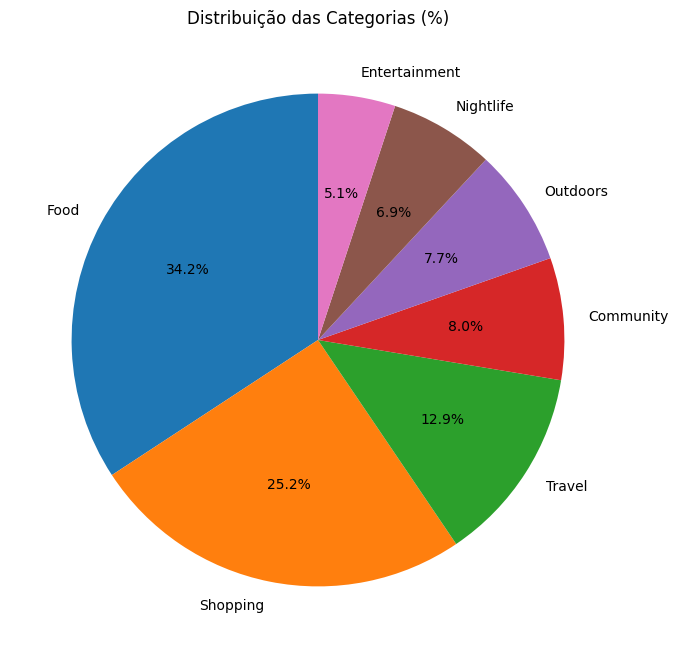

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(f"{pasta_output}/embeddings.csv")

category_counts = df["category"].value_counts()

category_percent = category_counts / category_counts.sum() * 100

plt.figure(figsize=(8, 8))
plt.pie(category_percent, labels=category_percent.index, autopct="%.1f%%", startangle=90)
plt.title("Distribuição das Categorias (%)")
plt.show()


### Concat


In [ ]:
limpar_pasta_output()

[OK] Todos os arquivos da pasta /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing foram removidos.


In [ ]:
save_poi_torch_to_csv_concat(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True,
)


[merged] shape (loc+time+category): (1224, 258)
Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/montana//embeddings.csv
Shape final: (1224, 258)
Dim original loc = 128, dim time = 128, dim concat = 256


placeid         0         1         2         3         4         5  \
0        9413  0.075818  0.096433  0.003761  0.002902  0.021295  0.036259   
1       57226  0.036804  0.026982  0.002965  0.306232  0.005811  0.000151   
2       57244  0.000039  0.008224  0.002842  0.247305  0.000899  0.057767   
3       57269  0.000594  0.071240  0.051311  0.006508  0.004737  0.004306   
4       57456  0.001080  0.002199  0.000169  0.127470  0.002673  0.057957   
...       ...       ...       ...       ...       ...       ...       ...   
1219  7555386  0.037427  0.019676  0.134612  0.070946  0.030466  0.153733   
1220  7562685  0.000066  0.001543  0.065072  0.000898  0.041531  0.000173   
1221  7562747  0.000915  0.001511  0.001434  0.000147  0.036498  0.000442   
1222  7563383  0.024904  0.000792  0.019675  0.066499  0.000285  0.020388   
1223  7565831  0.002669  0.002801  0.001377  0.001259  0.018748  0.002167   

             6         7         8  ...       247       248       249  \
0     0.091587  0.005398  0.044694  ...  0.002034  0.003619  0.006404   
1     0.148176  0.123950  0.004280  ... -0.014857  0.009450  0.010411   
2     0.112673  0.000802  0.073298  ...  0.064498 -0.011284  0.020967   
3     0.303737  0.005389  0.064614  ...  0.099807  0.048765 -0.001874   
4     0.000292  0.250790  0.006346  ... -0.044084 -0.010328 -0.009762   
...        ...       ...       ...  ...       ...       ...       ...   
1219  0.095261  0.080233  0.000764  ... -0.020923  0.027818  0.045111   
1220  0.046936  0.004711  0.003582  ...  0.010974  0.019721  0.014477   
1221  0.033632  0.000677  0.001113  ...  0.058905  0.047421  0.029248   
1222  0.055093  0.079431  0.002305  ...  0.120161  0.051380 -0.024618   
1223  0.001326  0.030598  0.001414  ... -0.150175 -0.149014 -0.128427   

           250       251       252       253       254       255   category  
0    -0.007862 -0.005932 -0.028791  0.016767 -0.006232 -0.001252     Travel  
1    -0.026386 -0.024395  0.002071  0.009101  0.056375  0.004864     Travel  
2     0.066720  0.038486 -0.033871  0.023752 -0.177180 -0.015909       Food  
3     0.083287  0.042381 -0.009304 -0.044802 -0.517260 -0.089743     Travel  
4    -0.061844  0.017297 -0.096324  0.043102 -0.123200  0.033445       Food  
...        ...       ...       ...       ...       ...       ...        ...  
1219 -0.074047 -0.164688  0.005649  0.078201  0.295954 -0.023557  Community  
1220 -0.036964  0.049378  0.079705 -0.074667  0.510630 -0.018840   Shopping  
1221  0.013630  0.059380  0.054692 -0.071219  0.468292 -0.024559       Food  
1222  0.085975  0.004657  0.067934 -0.103149 -0.568437 -0.137329   Outdoors  
1223 -0.141693  0.087701  0.076407 -0.102425  0.202679  0.025190  Community  

[1224 rows x 258 columns]

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet/src/data/create_input.py:415: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged[c] = merged[f"{c}_emb"] + merged[f"{c}_loc"]
/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet/src/data/create_input.py:415: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged[c] = merged[f"{c}_emb"] + merged[f"{c}_loc"]
/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet/src/data/create_input.py:415: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-11-07 03:32:21.820361: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 03:32:21.837246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762486341.857871    2331 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762486341.864201    2331 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762486341.879761    2331 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251024_1346"

### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score  \
0      Community  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
1  Entertainment  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
2           Food  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
3      Nightlife  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
4       Outdoors  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   

              support  
0   81366.67 ± 901.85  
1   24266.67 ± 757.19  
2  139800.00 ± 781.02  
3   16866.67 ± 404.15  
4  19066.67 ± 1159.02

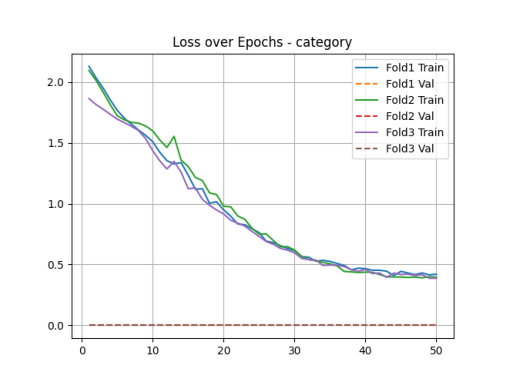

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score          support
0      Community   53.78 ± 2.75  75.65 ± 10.08   62.55 ± 2.40  4366.67 ± 57.74
1  Entertainment   18.84 ± 4.09   23.21 ± 9.28   20.62 ± 6.35   733.33 ± 57.74
2           Food   41.92 ± 8.34  12.22 ± 10.84  16.87 ± 13.45   6000.00 ± 0.00
3      Nightlife  34.44 ± 15.03   24.36 ± 8.41   26.27 ± 4.81  1233.33 ± 57.74
4       Outdoors   32.06 ± 7.78  54.03 ± 18.45   39.60 ± 9.67  1533.33 ± 57.74

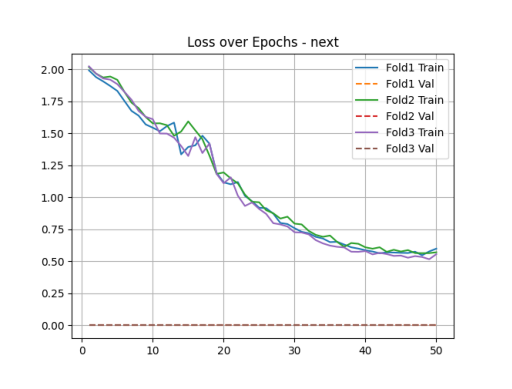

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

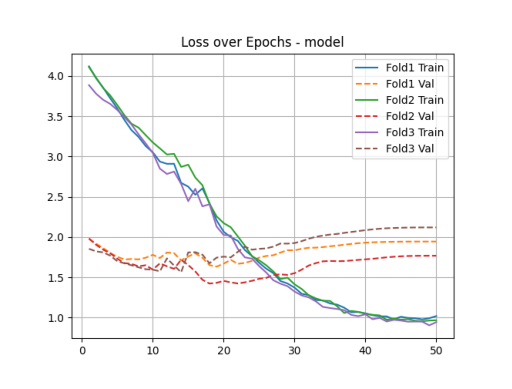

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## POI Embedding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [ ]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [ ]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_Montana.csv')

#### pois_gowalla

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pois_gowalla.csv'

#### poi-encoder-gowalla-h3.tensor

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,f"poi-encoder-gowalla-h3_{ESTADO.lower()}.tensor")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi-encoder-gowalla-h3.tensor")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/poi-encoder-gowalla-h3.tensor'

In [ ]:
import sys
import numpy as np
import pandas as pd
import torch

pois_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/pois_gowalla.csv")
tensor_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/poi-encoder-gowalla-h3.tensor")
filtrado_path = Path(f"{diretorio_principal}/data/checkins/checkins_{ESTADO.capitalize()}.csv")

def load_embedding_matrix(tensor_path: str, key: str = f"in_embed_{ESTADO.lower()}.weight") -> np.ndarray:
    """
    Carrega o .tensor (checkpoint PyTorch) e retorna um numpy array (num_fclass, emb_dim).
    """
    ckpt = torch.load(tensor_path, map_location="cpu")
    if key not in ckpt:
        raise KeyError(f"Chave '{key}' não encontrada no arquivo '{tensor_path}'. "
                       f"Chaves disponíveis: {list(ckpt.keys())[:10]}...")
    W = ckpt[key]
    if not isinstance(W, torch.Tensor):
        raise TypeError(f"Valor em '{key}' não é um torch.Tensor (veio {type(W)}).")
    if W.ndim != 2:
        raise ValueError(f"Esperado tensor 2D em '{key}', mas veio shape {tuple(W.shape)}.")
    return W.detach().cpu().numpy()


def build_output_df(pois_path: str, W: np.ndarray, filtrado_path: str) -> pd.DataFrame:
    """
    Gera o DataFrame final com:
      - placeid (copiado de feature_id)
      - emb_0 ... emb_(D-1) mapeados por fclass
      - category (join com filtrado.csv via placeid)
    """
    pois = pd.read_csv(pois_path)
    if "feature_id" not in pois.columns or "fclass" not in pois.columns:
        raise KeyError("O arquivo pois_gowalla.csv deve conter as colunas 'feature_id' e 'fclass'. "
                       f"Colunas encontradas: {list(pois.columns)}")

    pois["feature_id"] = pois["feature_id"].astype(str)
    try:
        pois["fclass"] = pois["fclass"].astype(int)
    except Exception as e:
        raise ValueError("Falha ao converter 'fclass' para int. "
                         "Verifique se há valores não numéricos.") from e

    num_classes, emb_dim = W.shape

    n = len(pois)
    emb = np.full((n, emb_dim), np.nan, dtype=float)

    valid = (pois["fclass"] >= 0) & (pois["fclass"] < num_classes)
    if not valid.all():
        invalid_rows = (~valid).sum()

    emb[valid.values] = W[pois.loc[valid, "fclass"].to_numpy()]

    emb_cols = [f"{i}" for i in range(emb_dim)]
    out = pd.DataFrame(emb, columns=emb_cols)
    out.insert(0, "placeid", pois["feature_id"].astype(str))

    filtrado = pd.read_csv(filtrado_path)

    if "placeid" not in filtrado.columns:
        if "feature_id" in filtrado.columns:
            filtrado = filtrado.rename(columns={"feature_id": "placeid"})
        else:
            raise KeyError("O arquivo filtrado.csv deve conter a coluna 'placeid'. "
                           f"Colunas encontradas: {list(filtrado.columns)}")

    if "category" not in filtrado.columns:
        raise KeyError("O arquivo filtrado.csv deve conter a coluna 'category'.")

    filtrado["placeid"] = filtrado["placeid"].astype(str)

    out = out.merge(filtrado[["placeid", "category"]], on="placeid", how="left")



    return out



In [ ]:
W =load_embedding_matrix(tensor_path)
out_df = build_output_df(pois_path, W, filtrado_path)


In [ ]:
pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
out_df.to_csv(f"{pasta_output}/embeddings-poi-encoder.csv", index=False)


In [ ]:
out_df.shape

(6171, 258)

### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 200, Total visit sequences: 654
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 200/200 [00:00<00:00, 36429.44it/s]
nextpoi_sequences shape: (654, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 1/1 [00:00<00:00,  2.78it/s, rows_written=654]
Finished: wrote 654 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-11-04 13:20:59.495556: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-04 13:20:59.513017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762262459.534292   21746 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762262459.540729   21746 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762262459.557059   21746 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251031_2029"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category      precision         recall      f1-score          support
0      Community    9.02 ± 4.76  22.47 ± 19.37  10.65 ± 4.61  1960.00 ± 54.77
1  Entertainment    0.00 ± 0.00    0.00 ± 0.00   0.00 ± 0.00  1240.00 ± 54.77
2           Food   38.74 ± 3.31   53.22 ± 8.92  44.45 ± 2.85  8380.00 ± 44.72
3      Nightlife    0.00 ± 0.00    0.00 ± 0.00   0.00 ± 0.00  1680.00 ± 44.72
4       Outdoors  29.88 ± 40.00    8.48 ± 7.95   9.70 ± 6.32  1880.00 ± 44.72

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category     precision         recall       f1-score          support
0      Community   8.14 ± 6.28  18.16 ± 14.37   10.11 ± 6.14  1960.00 ± 54.77
1  Entertainment   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00  1240.00 ± 54.77
2           Food  39.14 ± 3.61  41.48 ± 25.38  36.78 ± 10.34  8380.00 ± 44.72
3      Nightlife   1.54 ± 3.44    3.53 ± 7.89    2.14 ± 4.79  1680.00 ± 44.72
4       Outdoors  8.21 ± 11.25    5.26 ± 9.12    5.88 ± 9.22  1880.00 ± 44.72

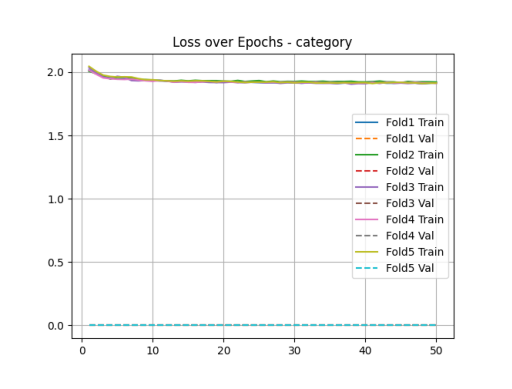

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score          support
0      Community  57.59 ± 10.01  63.36 ± 11.05   58.93 ± 1.49  2620.00 ± 44.72
1  Entertainment    9.95 ± 9.57  18.00 ± 10.37   11.61 ± 8.52   440.00 ± 54.77
2           Food   33.77 ± 7.99   17.78 ± 9.94  22.60 ± 10.26   3600.00 ± 0.00
3      Nightlife   16.11 ± 4.97   21.43 ± 6.68   18.10 ± 5.16   740.00 ± 54.77
4       Outdoors  31.41 ± 11.00   43.56 ± 1.99   35.73 ± 6.92   920.00 ± 44.72

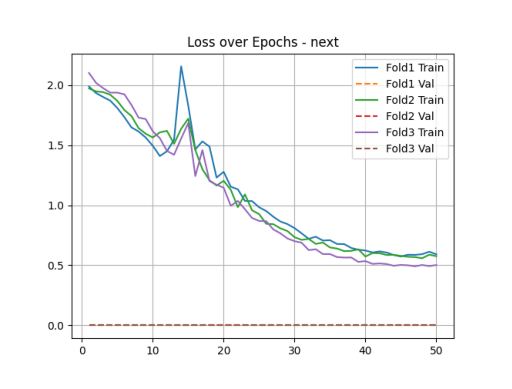

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

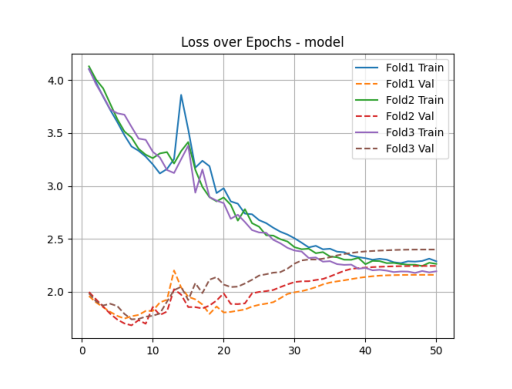

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## HGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

#### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/poi_embedding.torch'

#### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/filtrado.csv')

#### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pois_gowalla.csv'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama//embeddings.csv


placeid         0         1         2         3         4         5  \
0         9531 -0.328018 -0.279717 -0.268858 -0.025124 -0.033602  0.831421   
1         9532 -0.212724 -0.188304 -0.040483 -0.244203  1.012444  1.173037   
2         9533  0.957083 -0.120902  0.103594 -0.226602  0.106776  0.596069   
3         9593 -0.033946  0.299042  0.101730 -0.204093  0.044489  0.653744   
4         9693  0.615521 -0.025080 -0.066807 -0.233809 -0.017595  0.547271   
...        ...       ...       ...       ...       ...       ...       ...   
10264  7565433 -0.317049 -0.118215 -0.024992 -0.075344 -0.097142  0.470303   
10265  7568997  0.111724 -0.083904  0.190910  0.032612 -0.245301  0.713871   
10266  7570992  0.049874 -0.004915 -0.391894  0.467625  0.852172  0.454604   
10267  7574223 -0.295706  0.242828 -0.606082 -0.171838  1.712261  0.892785   
10268  7574363 -0.160191 -0.025299 -0.118098 -0.441647  0.820836  0.780606   

              6         7         8  ...        55        56        57  \
0      0.487451  0.345670 -0.051999  ...  0.382835  0.569170  0.062280   
1     -0.368704 -0.216277  0.044884  ... -0.090151  0.303618  0.442501   
2     -0.405396  0.028514  0.509419  ... -0.079732  0.831397  0.024735   
3      0.662394  0.550874  0.672326  ... -0.085716  0.441036  0.209071   
4     -0.263094 -0.132398 -0.088840  ... -0.188026  1.086916 -0.036607   
...         ...       ...       ...  ...       ...       ...       ...   
10264  1.184643 -0.310203  0.385223  ...  1.237868 -0.138529  1.750363   
10265  1.140990 -0.011070 -0.039734  ...  0.244286 -0.005502  0.883621   
10266  0.777993  0.827893 -0.138480  ...  0.350916  0.725459 -0.101077   
10267  1.275130  0.676823  1.093236  ...  2.273987 -0.580897  1.323805   
10268 -0.135789  0.593972 -0.227308  ... -0.098488  0.860860  0.346416   

             58        59        60        61        62        63  \
0     -0.175719  0.631150 -0.055097  0.027944  0.636096  0.206160   
1     -0.290301  0.510194 -0.057238 -0.213825  0.169952  0.980230   
2     -0.035905  0.493928 -0.049237  1.114538 -0.022972  0.607717   
3      1.268344 -0.063430 -0.185252  0.540702  0.180796 -0.019045   
4     -0.170019  0.699518 -0.245074  0.281830 -0.058471  0.175323   
...         ...       ...       ...       ...       ...       ...   
10264 -0.187174  0.915760 -0.043957  0.691891  0.626277  0.029799   
10265 -0.288049  0.223249 -0.191501  0.471388 -0.290527  0.050230   
10266 -0.175795  1.246596  0.750474  0.479635 -0.163431 -0.023801   
10267  0.547652  2.097080 -0.205113  0.026762 -0.269167  0.473824   
10268 -0.206023 -0.031804 -0.141015  1.123400  0.464607 -0.099695   

            category  
0           Shopping  
1          Community  
2           Outdoors  
3             Travel  
4      Entertainment  
...              ...  
10264           Food  
10265       Shopping  
10266         Travel  
10267           Food  
10268       Shopping  

[10269 rows x 66 columns]

### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 1432, Total visit sequences: 10426
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 1432/1432 [00:00<00:00, 18722.47it/s]
nextpoi_sequences shape: (10426, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 2/2 [00:07<00:00,  3.55s/it, rows_written=10426]
Finished: wrote 10426 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-23 21:03:55.217823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761253435.237416    7045 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761253435.243346    7045 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761253435.258139    7045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761253435.258164    7045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761253435.258169    7045 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251023_2104"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category     precision        recall      f1-score            support
0      Community  77.41 ± 4.07  75.57 ± 1.23  76.43 ± 1.97   53766.67 ± 57.74
1  Entertainment  71.98 ± 1.99  66.21 ± 0.86  68.96 ± 0.92   19233.33 ± 57.74
2           Food  79.85 ± 0.55  77.89 ± 1.17  78.86 ± 0.80  112633.33 ± 57.74
3      Nightlife  67.37 ± 1.99  63.72 ± 4.08  65.42 ± 2.03    9366.67 ± 57.74
4       Outdoors  71.63 ± 1.75  68.24 ± 2.46  69.89 ± 2.09    16900.00 ± 0.00

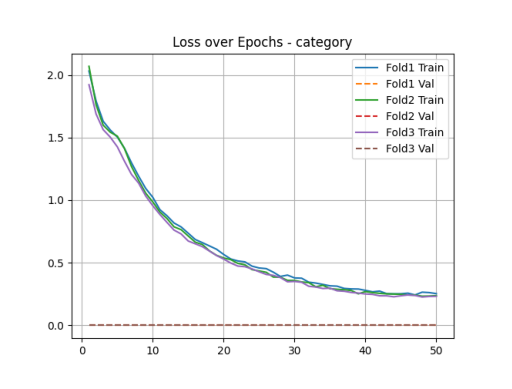

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category     precision         recall      f1-score            support
0      Community  39.23 ± 4.29   49.51 ± 5.02  43.54 ± 2.83   68133.33 ± 57.74
1  Entertainment  15.23 ± 1.78  33.05 ± 10.23  20.33 ± 0.28   20466.67 ± 57.74
2           Food  46.46 ± 4.02   23.77 ± 7.46  30.70 ± 6.14  118366.67 ± 57.74
3      Nightlife  14.41 ± 2.77   34.31 ± 7.86  19.83 ± 1.70    13600.00 ± 0.00
4       Outdoors  13.52 ± 2.40   19.31 ± 9.39  14.92 ± 1.33   16566.67 ± 57.74

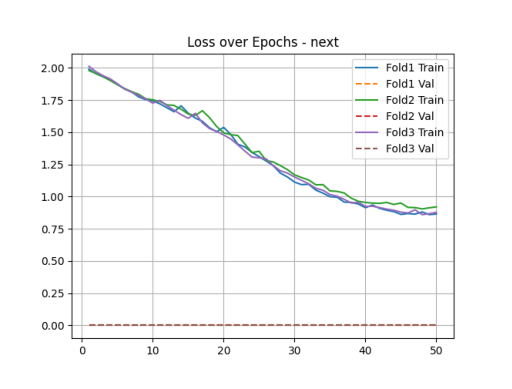

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

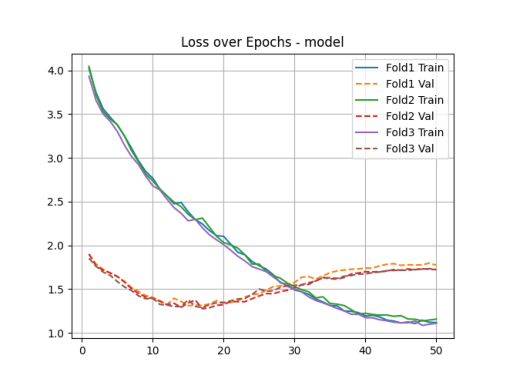

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## DGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [ ]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [ ]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_Alabama.csv')

# Florida

In [1]:
ESTADO = "florida"

In [2]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [4]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [5]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [6]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


In [7]:
import os
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)


## HGI com Time + Location Encoding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [16]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/poi_embedding.torch'

### checkins filtrados

In [17]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/filtrado.csv')

### pois_gowalla

In [18]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pois_gowalla.csv'

In [19]:
import pandas as pd
teste = pd.read_csv(f"{output_state_dir}/pois_gowalla.csv")
teste.shape

(65009, 4)

In [20]:
time_csv = pd.read_csv(f"{diretorio_region_embedding}/time_encoder_embeddings_sin_checkin_{ESTADO.lower()}.csv")
time_csv.shape

(990518, 130)

In [21]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"

def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (
        chk.dropna(subset=["category"])
           .groupby("placeid")["category"]
           .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    )
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True,
    peso_location=0.5,
):
    peso_time = 1.0 - peso_location

    emb_loc = load_tensor(path_torch)
    V, D = emb_loc.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    loc_cols = [f"loc_{i}" for i in range(D)]
    df_loc = pd.DataFrame(emb_loc, columns=loc_cols)
    df_loc.insert(0, "placeid", placeids)
    df_loc["placeid"] = df_loc["placeid"].astype(str)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df_loc["category"] = df_loc["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df_loc["category"] = np.nan
    else:
        df_loc["category"] = np.nan

    time_csv = f"{diretorio_region_embedding}/time_encoder_embeddings_sin_checkin_{ESTADO}.csv"
    if not os.path.exists(time_csv):
        raise FileNotFoundError(f"Arquivo de time embeddings não encontrado: {time_csv}")

    time_df = pd.read_csv(time_csv)
    if "placeid" not in time_df.columns:
        raise KeyError("time_encoder_embeddings_sin_checkin CSV precisa conter a coluna 'placeid'.")

    time_df["placeid"] = time_df["placeid"].astype(str)

    time_emb_cols = [str(i) for i in range(D) if str(i) in time_df.columns]
    if len(time_emb_cols) != D:
        print(f"[AVISO] Esperava {D} colunas de embedding de tempo (0..{D-1}), "
              f"mas encontrei {len(time_emb_cols)}. Usando apenas as existentes.")

    time_agg = (
        time_df
        .groupby("placeid")[time_emb_cols]
        .mean()
        .reset_index()
    )

    rename_map = {c: f"time_{c}" for c in time_emb_cols}
    time_agg = time_agg.rename(columns=rename_map)

    merged = df_loc.merge(time_agg, on="placeid", how="inner")

    final_emb_cols = [str(i) for i in range(D)]
    for i in range(D):
        loc_col = f"loc_{i}"
        time_col = f"time_{i}"
        if loc_col not in merged.columns or time_col not in merged.columns:
            raise KeyError(f"Colunas esperadas não encontradas: {loc_col} ou {time_col}")
        merged[str(i)] = (
            peso_location * merged[loc_col] +
            peso_time     * merged[time_col]
        )

    cols_final = ["placeid"] + final_emb_cols + ["category"]
    df_final = merged[cols_final]

    df_final.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    print("Shape final:", df_final.shape)
    print(f"peso_location = {peso_location:.2f} | peso_time = {peso_time:.2f}")
    return df_final




In [22]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"

def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (
        chk.dropna(subset=["category"])
           .groupby("placeid")["category"]
           .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    )
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv_concat(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True,
):
    emb_loc = load_tensor(path_torch)
    V, D = emb_loc.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    loc_cols = [f"loc_{i}" for i in range(D)]
    df_loc = pd.DataFrame(emb_loc, columns=loc_cols)
    df_loc.insert(0, "placeid", placeids)
    df_loc["placeid"] = df_loc["placeid"].astype(str)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df_loc["category"] = df_loc["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df_loc["category"] = np.nan
    else:
        df_loc["category"] = np.nan

    time_csv = f"{diretorio_region_embedding}/time_encoder_embeddings_sin_checkin_{ESTADO}.csv"
    if not os.path.exists(time_csv):
        raise FileNotFoundError(f"Arquivo de time embeddings não encontrado: {time_csv}")

    time_df = pd.read_csv(time_csv)
    if "placeid" not in time_df.columns:
        raise KeyError("time_encoder_embeddings_sin_checkin CSV precisa conter a coluna 'placeid'.")

    time_df["placeid"] = time_df["placeid"].astype(str)

    time_emb_cols = [str(i) for i in range(D) if str(i) in time_df.columns]
    if len(time_emb_cols) != D:
        print(f"[AVISO] Esperava {D} colunas de embedding de tempo (0..{D-1}), "
              f"mas encontrei {len(time_emb_cols)}. Usando apenas as existentes.")
        D = len(time_emb_cols)

    time_agg = (
        time_df
        .groupby("placeid")[time_emb_cols]
        .mean()
        .reset_index()
    )

    rename_map = {c: f"time_{c}" for c in time_emb_cols}
    time_agg = time_agg.rename(columns=rename_map)
    time_cols = [f"time_{c}" for c in time_emb_cols]

    merged = df_loc.merge(time_agg, on="placeid", how="inner")
    print("[merged] shape (loc+time+category):", merged.shape)

    concat_array = np.hstack([
        merged[loc_cols].values.astype(np.float32),
        merged[time_cols].values.astype(np.float32),
    ])

    new_D = concat_array.shape[1]
    emb_cols = [str(i) for i in range(new_D)]
    df_final = pd.DataFrame(concat_array, columns=emb_cols)
    df_final.insert(0, "placeid", merged["placeid"].values)
    df_final["category"] = merged["category"].values

    df_final.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    print("Shape final:", df_final.shape)
    print(f"Dim original loc = {len(loc_cols)}, dim time = {len(time_cols)}, dim concat = {new_D}")
    return df_final


In [23]:
def limpar_pasta_output():
    pasta = os.path.join(diretorio_principal, "data", "output", ESTADO,"pre-processing")
    if not os.path.exists(pasta):
        print(f"[AVISO] Pasta não encontrada: {pasta}")
        return

    arquivos = os.listdir(pasta)
    if not arquivos:
        print(f"[INFO] A pasta {pasta} já está vazia.")
        return

    for nome in arquivos:
        caminho = os.path.join(pasta, nome)
        try:
            if os.path.isfile(caminho) or os.path.islink(caminho):
                os.remove(caminho)
            elif os.path.isdir(caminho):
                shutil.rmtree(caminho)
        except Exception as e:
            print(f"[ERRO] Falha ao remover {caminho}: {e}")

    print(f"[OK] Todos os arquivos da pasta {pasta} foram removidos.")


### Treino com novo modelo de embeddings pelo HGI

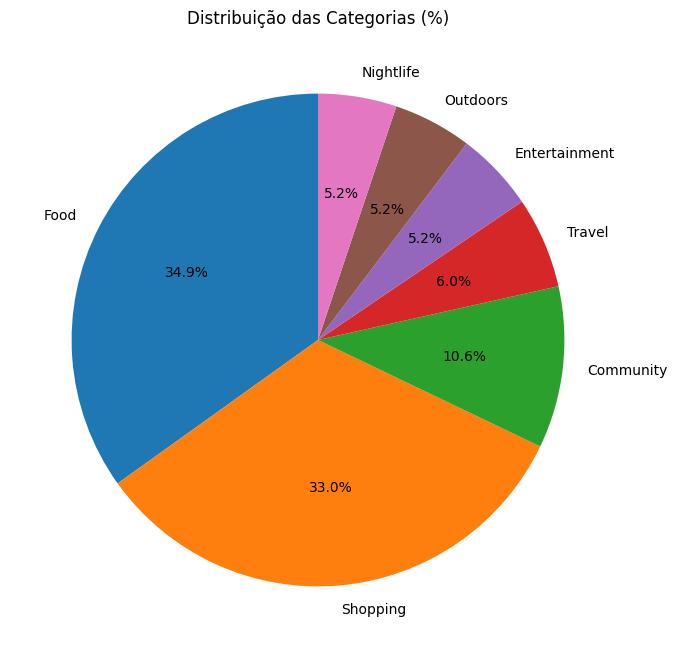

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(f"{pasta_output}/embeddings.csv")

category_counts = df["category"].value_counts()

category_percent = category_counts / category_counts.sum() * 100

plt.figure(figsize=(8, 8))
plt.pie(category_percent, labels=category_percent.index, autopct="%.1f%%", startangle=90)
plt.title("Distribuição das Categorias (%)")
plt.show()


In [25]:
limpar_pasta_output()

[OK] Todos os arquivos da pasta /content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pre-processing foram removidos.


### Concat


In [ ]:
limpar_pasta_output()

[OK] Todos os arquivos da pasta /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing foram removidos.


In [26]:
save_poi_torch_to_csv_concat(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True,
)


[merged] shape (loc+time+category): (65009, 258)
Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/florida//embeddings.csv
Shape final: (65009, 258)
Dim original loc = 128, dim time = 128, dim concat = 256


placeid         0         1         2         3         4         5  \
0         9322  0.176257 -0.008030  0.035665 -0.000884  0.077636 -0.000710   
1         9325  0.141460  0.042481 -0.003497  0.080289  0.061283  0.217718   
2         9342  0.259174  0.168164 -0.004607 -0.003378 -0.005944  0.022116   
3         9345  0.057422  0.132713 -0.003194  0.194738  0.201047  0.119892   
4         9454 -0.002730 -0.000851  0.088670 -0.003285  0.013881  0.130363   
...        ...       ...       ...       ...       ...       ...       ...   
65004  7653440  0.011109  0.021031 -0.001586  0.118807  0.012029 -0.002400   
65005  7653466  0.100255  0.031143 -0.003051 -0.001015 -0.001364 -0.000856   
65006  7653536  0.131309 -0.000518  0.017682  0.081540 -0.005163 -0.000790   
65007  7678396  0.170885  0.000830 -0.004176  0.054612 -0.001622  0.073787   
65008  7696696 -0.000440 -0.002891  0.005548  0.005134 -0.001065  0.027979   

              6         7         8  ...       247       248       249  \
0     -0.003196  0.069906 -0.001439  ...  0.024083 -0.008405 -0.009009   
1      0.182609  0.080079  0.102470  ...  0.030037 -0.008291 -0.004026   
2      0.132393 -0.011478 -0.005664  ... -0.022242  0.014636 -0.003936   
3     -0.000347  0.120541 -0.004401  ... -0.027472 -0.003354  0.012475   
4     -0.005090 -0.001592  0.076427  ... -0.003315  0.007438 -0.000571   
...         ...       ...       ...  ...       ...       ...       ...   
65004 -0.000260 -0.001720 -0.000794  ... -0.231509 -0.066471  0.004447   
65005  0.090323 -0.003763  0.085409  ... -0.233255 -0.067509  0.008963   
65006  0.122182 -0.002555 -0.000892  ...  0.014858  0.039588 -0.139180   
65007 -0.001581  0.000260 -0.000448  ...  0.109894 -0.052781  0.016059   
65008  0.067156 -0.004639  0.091632  ...  0.033582  0.029140  0.094348   

            250       251       252       253       254       255   category  
0     -0.009983 -0.000068  0.014115  0.126815  0.033081 -0.027882  Community  
1     -0.016861 -0.021597  0.011985  0.011020  0.034174 -0.011233   Outdoors  
2     -0.010719  0.011587  0.010326 -0.003257  0.011043 -0.006059     Travel  
3     -0.014106  0.013089 -0.003689 -0.040967  0.015971 -0.000930   Shopping  
4      0.000546 -0.006879 -0.013215  0.010997  0.000333  0.010232   Shopping  
...         ...       ...       ...       ...       ...       ...        ...  
65004  0.004067  0.066524  0.046062 -0.069765  0.080694 -0.048016   Shopping  
65005  0.001520  0.068995  0.048704 -0.072157  0.081027 -0.049790  Nightlife  
65006  0.075995 -0.088401  0.053912 -0.035583 -0.009006 -0.089308     Travel  
65007  0.086059  0.125932 -0.042887  0.134735 -0.065690  0.075941   Shopping  
65008  0.018207  0.099408  0.099673 -0.086170 -0.018064 -0.043005       Food  

[65009 rows x 258 columns]

In [27]:
!python -m pipelines.create_inputs {ESTADO}

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet/src/data/create_input.py:415: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged[c] = merged[f"{c}_emb"] + merged[f"{c}_loc"]
/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet/src/data/create_input.py:415: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged[c] = merged[f"{c}_emb"] + merged[f"{c}_loc"]
/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet/src/data/create_input.py:415: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-11-07 12:33:31.824393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 12:33:31.841295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762518811.862721    1223 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762518811.869112    1223 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762518811.887181    1223 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251024_1346"

### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score  \
0      Community  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
1  Entertainment  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
2           Food  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
3      Nightlife  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   
4       Outdoors  100.00 ± 0.00  100.00 ± 0.00  100.00 ± 0.00   

              support  
0   81366.67 ± 901.85  
1   24266.67 ± 757.19  
2  139800.00 ± 781.02  
3   16866.67 ± 404.15  
4  19066.67 ± 1159.02

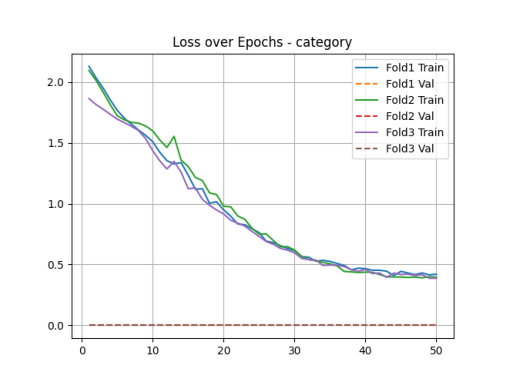

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score          support
0      Community   53.78 ± 2.75  75.65 ± 10.08   62.55 ± 2.40  4366.67 ± 57.74
1  Entertainment   18.84 ± 4.09   23.21 ± 9.28   20.62 ± 6.35   733.33 ± 57.74
2           Food   41.92 ± 8.34  12.22 ± 10.84  16.87 ± 13.45   6000.00 ± 0.00
3      Nightlife  34.44 ± 15.03   24.36 ± 8.41   26.27 ± 4.81  1233.33 ± 57.74
4       Outdoors   32.06 ± 7.78  54.03 ± 18.45   39.60 ± 9.67  1533.33 ± 57.74

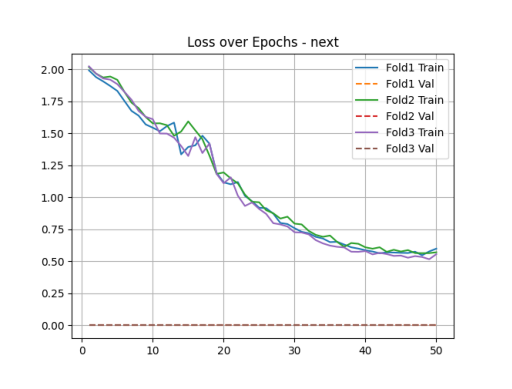

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

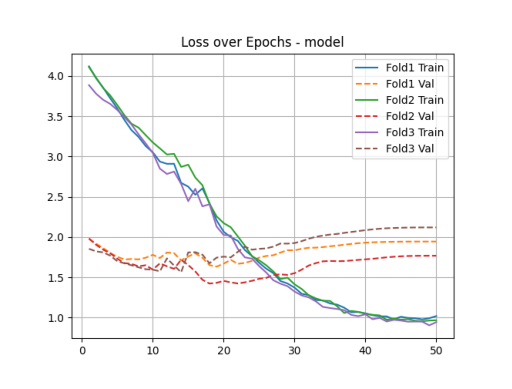

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## POI Embedding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [8]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [9]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_Florida.csv')

#### pois_gowalla

In [10]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pois_gowalla.csv'

#### poi-encoder-gowalla-h3.tensor

In [11]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,f"poi-encoder-gowalla-h3_{ESTADO.lower()}.tensor")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi-encoder-gowalla-h3.tensor")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/poi-encoder-gowalla-h3.tensor'

In [12]:
import sys
import numpy as np
import pandas as pd
import torch

pois_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/pois_gowalla.csv")
tensor_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/poi-encoder-gowalla-h3.tensor")
filtrado_path = Path(f"{diretorio_principal}/data/checkins/checkins_{ESTADO.capitalize()}.csv")

def load_embedding_matrix(tensor_path: str, key: str = f"in_embed_{ESTADO.lower()}.weight") -> np.ndarray:
    """
    Carrega o .tensor (checkpoint PyTorch) e retorna um numpy array (num_fclass, emb_dim).
    """
    ckpt = torch.load(tensor_path, map_location="cpu")
    if key not in ckpt:
        raise KeyError(f"Chave '{key}' não encontrada no arquivo '{tensor_path}'. "
                       f"Chaves disponíveis: {list(ckpt.keys())[:10]}...")
    W = ckpt[key]
    if not isinstance(W, torch.Tensor):
        raise TypeError(f"Valor em '{key}' não é um torch.Tensor (veio {type(W)}).")
    if W.ndim != 2:
        raise ValueError(f"Esperado tensor 2D em '{key}', mas veio shape {tuple(W.shape)}.")
    return W.detach().cpu().numpy()


def build_output_df(pois_path: str, W: np.ndarray, filtrado_path: str) -> pd.DataFrame:
    """
    Gera o DataFrame final com:
      - placeid (copiado de feature_id)
      - emb_0 ... emb_(D-1) mapeados por fclass
      - category (join com filtrado.csv via placeid)
    """
    pois = pd.read_csv(pois_path)
    if "feature_id" not in pois.columns or "fclass" not in pois.columns:
        raise KeyError("O arquivo pois_gowalla.csv deve conter as colunas 'feature_id' e 'fclass'. "
                       f"Colunas encontradas: {list(pois.columns)}")

    pois["feature_id"] = pois["feature_id"].astype(str)
    try:
        pois["fclass"] = pois["fclass"].astype(int)
    except Exception as e:
        raise ValueError("Falha ao converter 'fclass' para int. "
                         "Verifique se há valores não numéricos.") from e

    num_classes, emb_dim = W.shape

    n = len(pois)
    emb = np.full((n, emb_dim), np.nan, dtype=float)

    valid = (pois["fclass"] >= 0) & (pois["fclass"] < num_classes)
    if not valid.all():
        invalid_rows = (~valid).sum()

    emb[valid.values] = W[pois.loc[valid, "fclass"].to_numpy()]

    emb_cols = [f"{i}" for i in range(emb_dim)]
    out = pd.DataFrame(emb, columns=emb_cols)
    out.insert(0, "placeid", pois["feature_id"].astype(str))

    filtrado = pd.read_csv(filtrado_path)

    if "placeid" not in filtrado.columns:
        if "feature_id" in filtrado.columns:
            filtrado = filtrado.rename(columns={"feature_id": "placeid"})
        else:
            raise KeyError("O arquivo filtrado.csv deve conter a coluna 'placeid'. "
                           f"Colunas encontradas: {list(filtrado.columns)}")

    if "category" not in filtrado.columns:
        raise KeyError("O arquivo filtrado.csv deve conter a coluna 'category'.")

    filtrado["placeid"] = filtrado["placeid"].astype(str)

    out = out.merge(filtrado[["placeid", "category"]], on="placeid", how="left")



    return out



In [13]:
W =load_embedding_matrix(tensor_path)
out_df = build_output_df(pois_path, W, filtrado_path)


In [14]:
pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
out_df.to_csv(f"{pasta_output}/embeddings-poi-encoder.csv", index=False)


In [15]:
out_df.shape

(990518, 258)

### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 200, Total visit sequences: 654
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 200/200 [00:00<00:00, 36429.44it/s]
nextpoi_sequences shape: (654, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 1/1 [00:00<00:00,  2.78it/s, rows_written=654]
Finished: wrote 654 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-11-04 13:20:59.495556: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-04 13:20:59.513017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762262459.534292   21746 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762262459.540729   21746 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762262459.557059   21746 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251031_2029"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category      precision         recall      f1-score          support
0      Community    9.02 ± 4.76  22.47 ± 19.37  10.65 ± 4.61  1960.00 ± 54.77
1  Entertainment    0.00 ± 0.00    0.00 ± 0.00   0.00 ± 0.00  1240.00 ± 54.77
2           Food   38.74 ± 3.31   53.22 ± 8.92  44.45 ± 2.85  8380.00 ± 44.72
3      Nightlife    0.00 ± 0.00    0.00 ± 0.00   0.00 ± 0.00  1680.00 ± 44.72
4       Outdoors  29.88 ± 40.00    8.48 ± 7.95   9.70 ± 6.32  1880.00 ± 44.72

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category     precision         recall       f1-score          support
0      Community   8.14 ± 6.28  18.16 ± 14.37   10.11 ± 6.14  1960.00 ± 54.77
1  Entertainment   0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00  1240.00 ± 54.77
2           Food  39.14 ± 3.61  41.48 ± 25.38  36.78 ± 10.34  8380.00 ± 44.72
3      Nightlife   1.54 ± 3.44    3.53 ± 7.89    2.14 ± 4.79  1680.00 ± 44.72
4       Outdoors  8.21 ± 11.25    5.26 ± 9.12    5.88 ± 9.22  1880.00 ± 44.72

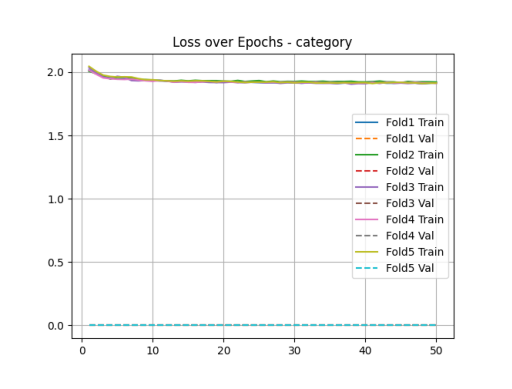

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category      precision         recall       f1-score          support
0      Community  57.59 ± 10.01  63.36 ± 11.05   58.93 ± 1.49  2620.00 ± 44.72
1  Entertainment    9.95 ± 9.57  18.00 ± 10.37   11.61 ± 8.52   440.00 ± 54.77
2           Food   33.77 ± 7.99   17.78 ± 9.94  22.60 ± 10.26   3600.00 ± 0.00
3      Nightlife   16.11 ± 4.97   21.43 ± 6.68   18.10 ± 5.16   740.00 ± 54.77
4       Outdoors  31.41 ± 11.00   43.56 ± 1.99   35.73 ± 6.92   920.00 ± 44.72

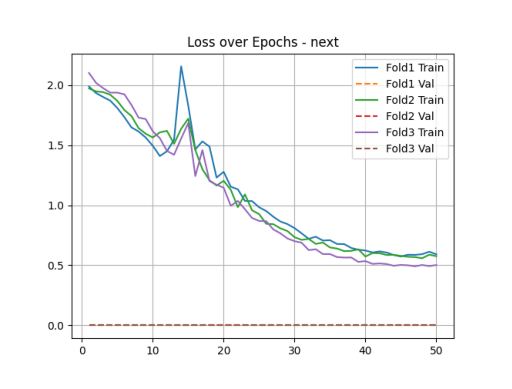

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

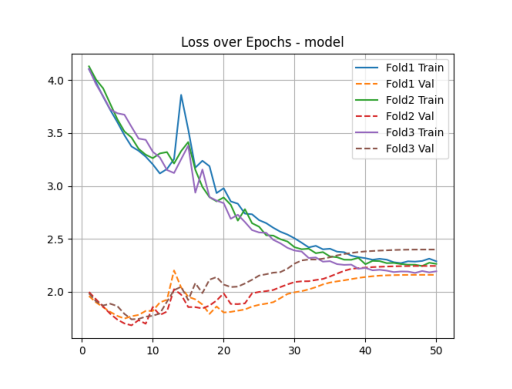

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## HGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

#### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/poi_embedding.torch'

#### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/filtrado.csv')

#### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pois_gowalla.csv'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama//embeddings.csv


placeid         0         1         2         3         4         5  \
0         9531 -0.328018 -0.279717 -0.268858 -0.025124 -0.033602  0.831421   
1         9532 -0.212724 -0.188304 -0.040483 -0.244203  1.012444  1.173037   
2         9533  0.957083 -0.120902  0.103594 -0.226602  0.106776  0.596069   
3         9593 -0.033946  0.299042  0.101730 -0.204093  0.044489  0.653744   
4         9693  0.615521 -0.025080 -0.066807 -0.233809 -0.017595  0.547271   
...        ...       ...       ...       ...       ...       ...       ...   
10264  7565433 -0.317049 -0.118215 -0.024992 -0.075344 -0.097142  0.470303   
10265  7568997  0.111724 -0.083904  0.190910  0.032612 -0.245301  0.713871   
10266  7570992  0.049874 -0.004915 -0.391894  0.467625  0.852172  0.454604   
10267  7574223 -0.295706  0.242828 -0.606082 -0.171838  1.712261  0.892785   
10268  7574363 -0.160191 -0.025299 -0.118098 -0.441647  0.820836  0.780606   

              6         7         8  ...        55        56        57  \
0      0.487451  0.345670 -0.051999  ...  0.382835  0.569170  0.062280   
1     -0.368704 -0.216277  0.044884  ... -0.090151  0.303618  0.442501   
2     -0.405396  0.028514  0.509419  ... -0.079732  0.831397  0.024735   
3      0.662394  0.550874  0.672326  ... -0.085716  0.441036  0.209071   
4     -0.263094 -0.132398 -0.088840  ... -0.188026  1.086916 -0.036607   
...         ...       ...       ...  ...       ...       ...       ...   
10264  1.184643 -0.310203  0.385223  ...  1.237868 -0.138529  1.750363   
10265  1.140990 -0.011070 -0.039734  ...  0.244286 -0.005502  0.883621   
10266  0.777993  0.827893 -0.138480  ...  0.350916  0.725459 -0.101077   
10267  1.275130  0.676823  1.093236  ...  2.273987 -0.580897  1.323805   
10268 -0.135789  0.593972 -0.227308  ... -0.098488  0.860860  0.346416   

             58        59        60        61        62        63  \
0     -0.175719  0.631150 -0.055097  0.027944  0.636096  0.206160   
1     -0.290301  0.510194 -0.057238 -0.213825  0.169952  0.980230   
2     -0.035905  0.493928 -0.049237  1.114538 -0.022972  0.607717   
3      1.268344 -0.063430 -0.185252  0.540702  0.180796 -0.019045   
4     -0.170019  0.699518 -0.245074  0.281830 -0.058471  0.175323   
...         ...       ...       ...       ...       ...       ...   
10264 -0.187174  0.915760 -0.043957  0.691891  0.626277  0.029799   
10265 -0.288049  0.223249 -0.191501  0.471388 -0.290527  0.050230   
10266 -0.175795  1.246596  0.750474  0.479635 -0.163431 -0.023801   
10267  0.547652  2.097080 -0.205113  0.026762 -0.269167  0.473824   
10268 -0.206023 -0.031804 -0.141015  1.123400  0.464607 -0.099695   

            category  
0           Shopping  
1          Community  
2           Outdoors  
3             Travel  
4      Entertainment  
...              ...  
10264           Food  
10265       Shopping  
10266         Travel  
10267           Food  
10268       Shopping  

[10269 rows x 66 columns]

### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 1432, Total visit sequences: 10426
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 1432/1432 [00:00<00:00, 18722.47it/s]
nextpoi_sequences shape: (10426, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 2/2 [00:07<00:00,  3.55s/it, rows_written=10426]
Finished: wrote 10426 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-23 21:03:55.217823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761253435.237416    7045 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761253435.243346    7045 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761253435.258139    7045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761253435.258164    7045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761253435.258169    7045 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251023_2104"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

Category     precision        recall      f1-score            support
0      Community  77.41 ± 4.07  75.57 ± 1.23  76.43 ± 1.97   53766.67 ± 57.74
1  Entertainment  71.98 ± 1.99  66.21 ± 0.86  68.96 ± 0.92   19233.33 ± 57.74
2           Food  79.85 ± 0.55  77.89 ± 1.17  78.86 ± 0.80  112633.33 ± 57.74
3      Nightlife  67.37 ± 1.99  63.72 ± 4.08  65.42 ± 2.03    9366.67 ± 57.74
4       Outdoors  71.63 ± 1.75  68.24 ± 2.46  69.89 ± 2.09    16900.00 ± 0.00

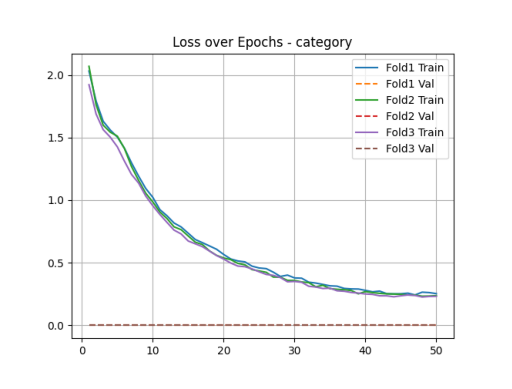

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

Category     precision         recall      f1-score            support
0      Community  39.23 ± 4.29   49.51 ± 5.02  43.54 ± 2.83   68133.33 ± 57.74
1  Entertainment  15.23 ± 1.78  33.05 ± 10.23  20.33 ± 0.28   20466.67 ± 57.74
2           Food  46.46 ± 4.02   23.77 ± 7.46  30.70 ± 6.14  118366.67 ± 57.74
3      Nightlife  14.41 ± 2.77   34.31 ± 7.86  19.83 ± 1.70    13600.00 ± 0.00
4       Outdoors  13.52 ± 2.40   19.31 ± 9.39  14.92 ± 1.33   16566.67 ± 57.74

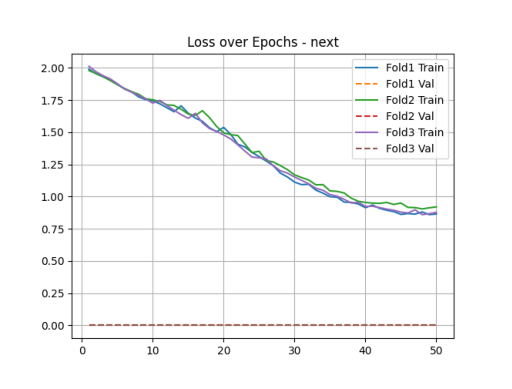

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

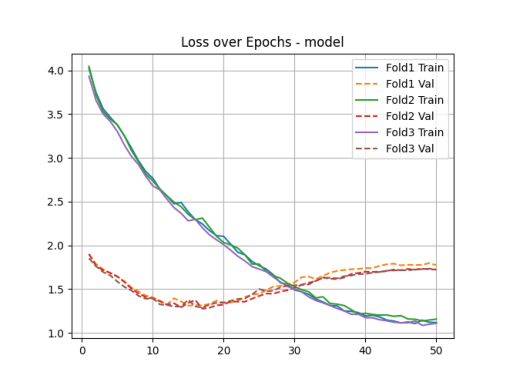

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## DGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [ ]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [ ]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_Alabama.csv')